# Predicting elections with machine learning

This is a refined version of the candidate model presented in the ex-ante-forecast-2023.ipynb. This notebook includes deeper analysis and adds additional features.

## Content: 
* Loading and preprocessing data
* Descriptive statistics
* Helper functions for model evaluation
* Machine learning models
  * XGBoost Regressor
  * Random Forest Regressor
  * Linear Regression
  * Ridge Regression
  * MLP Regressor
  * Linear SVR
  * K-Neighbors Regressor
* D'Hondt result calculation
* Model evaluation with SHAP analysis
* Performance evaluation
  * National results comparison
  * Seats prediction accuracy
  * Model comparison metrics
* Ranked correlation analysis (Kendall's Tau)
* Hyperparameter tuning with Optuna
* Residual analysis by subgroups


## Loading and preprocessing data

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import sidetable as stb
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# set float format to only show 2 digits
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.options.mode.chained_assignment = None

In [2]:
# Define features
features = ['party_prefvote_lag',
            'prefvote_lag',
            'age',
            'sex',
            'fb_likes',
            'last_municipal_votes',
            'last_eu_votes',
            'political_experience',
            'adjusted_campaign_budget_scale',
            'twitter_followers',
            'scaled_candidate_nr'
           ]

feature_names = ['Party Preference in Previous Votes',
                 'Preference Votes in Previous Election',
                 'Candidate Age',
                 'Candidate Sex',
                 'Facebook Likes',
                 'Votes in Last Municipal Election',
                 'Votes in Last European Election',
                 'Political Experience',
                 'Adjusted Scale of Campaign Budget',
                 'Twitter Followers Count',
                 'Scaled Candidate Number'
                ]


In [3]:
candidates = pd.read_csv('raw_data.csv', sep=';', decimal=',')
districts = pd.read_csv('districts.csv', sep=';', decimal=',')
polls = pd.read_csv('polls.csv', sep=';', decimal=',')

In [4]:
candidates["president_candidate"] = np.where(candidates['last_presidential_elections'] > 0, 1, 0)
candidates["eu_candidate"] = np.where(candidates['last_eu_votes'] > 0, 1, 0)
candidates["municipal_candidate"] = np.where(candidates['last_municipal_votes'] > 0, 1, 0)
candidates["pyear_run"] = np.where(candidates['prefvote_lag'] > 0, 1, 0)


In [5]:
# Calculate political experience by summing up various political-related columns

# 'mep': Indicates if the candidate has been a Member of the European Parliament (1 if yes, 0 if no)
# 'prevterm': Represents if the candidate has served in a previous term in Finnish parliament (1 if yes, 0 if no)
# 'regional_seat': Denotes if the candidate holds a regional government seat (1 if yes, 0 if no)
# 'municipal_seat': Specifies if the candidate holds a municipal government seat (1 if yes, 0 if no)
# 'eu_candidate': Indicates if the candidate ran for Member of the European Parliament (1 if yes, 0 if no)
# 'president_candidate': Denotes if the candidate has run for presidency (1 if yes, 0 if no)
# 'municipal_candidate': Specifies if the candidate has run for a municipal seat (1 if yes, 0 if no)
# 'pyear_run': Indicates if the candidate was a candidate in the last parliamentary elections (1 if yes, 0 if no)

# Creating a new column 'political_experience' by adding up the above political variables
candidates["political_experience"] = (
    candidates["mep"] + 
    candidates["prevterm"] + 
    candidates["regional_seat"] + 
    candidates["municipal_seat"] + 
    candidates["eu_candidate"] + 
    candidates["president_candidate"] + 
    candidates["municipal_candidate"] + 
    candidates["pyear_run"]
)

In [6]:
# The campaign budget must be mappend to comparable categories or ordinal values, because the categories have changed between elections.
# Ordinal might be the best approach as we don't know the possible categories in the next elections.  

# save the reported to later
candidates['campaign_budget_reported'] = candidates["campaign_budget"]

candidates.groupby(['campaign_budget']).agg({'prefvote':['mean','max', 'std', 'count'],'fb_likes': ['mean','max']}).stb.flatten().sort_values(by='prefvote_mean')

budget_scale_mapper = {"500-1000 euroa":1, "alle 1000 euroa":1, "alle 500 euroa":1, 
                       "1000-3000 euroa":2, "1000-5000 euroa":2, "3000-5000 euroa":2,
                       "5000-8000 euroa":3, "5000-10000 euroa":3, "8000-10000 euroa":3,
                       "10000-20000 euroa":4, 
                       "20000-30000 euroa":5, "30000-40000 euroa":5,"40000-50000 euroa":5, "20000-50000 euroa":5,
                        "yli 50000 euroa":6, 
                        "Ei halua sanoa":0, 
                        "na":0,
                        "0":0}
candidates["campaign_budget_scale"] = candidates["campaign_budget"].replace(budget_scale_mapper)

# # Same for education
candidates.groupby(['education']).agg({'prefvote':['mean','max', 'std'],'fb_likes': ['mean','max']}).stb.flatten().sort_values(by='prefvote_mean')
education_scale_mapper = {"Ei halua sanoa": 2, "joku muu": 2, "peruskoulu" : 1, "ammattitutkinto" : 2, "ylioppilas" : 3, "korkeakoulututkinto" : 4, "na" : np.nan}
candidates["education_scale"] = candidates["education"].replace(education_scale_mapper)

/var/folders/rw/tlr4y3fj0yd2_c4p1sgqzcg80000gn/T/ipykernel_41744/1851091531.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  candidates["campaign_budget_scale"] = candidates["campaign_budget"].replace(budget_scale_mapper)


In [7]:
#map 2023

bins = [0,1000,5000,10000, 20000, 50000, 1000000]
labels = [1,2,3,4,5,6]


candidates["campaign_budget_scale_2023"] = pd.cut(candidates["campaign_budget_2023"], bins=bins, labels=labels)
candidates["campaign_budget_scale_2023"] = pd.to_numeric(candidates["campaign_budget_scale_2023"], errors='coerce').fillna(0).astype(int)

In [8]:
# combine 2023 with past
candidates.loc[candidates['campaign_budget_scale_2023'] > candidates['campaign_budget_scale'], 'campaign_budget_scale'] = candidates['campaign_budget_scale_2023']

In [9]:

# Impute missing values with party - district average
# Compute the mean 'campaign_budget_scale' for each combination of 'party', 'district', and 'year'
group_mean = candidates.groupby(['party', 'district', 'year'])['campaign_budget_scale'].transform('mean')

group_mean_rounded = group_mean.round()

# Fill NaN values with the rounded group mean
candidates['adjusted_campaign_budget_scale'] = candidates['campaign_budget_scale'].fillna(group_mean_rounded)

# Replace 0 values in the new column, adjusted separately since fillna does not handle zeros
candidates.loc[candidates['adjusted_campaign_budget_scale'] == 0, 'adjusted_campaign_budget_scale'] = group_mean_rounded[candidates['adjusted_campaign_budget_scale'] == 0]

In [10]:
# Include ballot position bias:
scaler = MinMaxScaler()
candidates['log_candidate_nr'] = np.log(candidates['candidate_nr'])
candidates['scaled_candidate_nr'] = scaler.fit_transform(candidates[['log_candidate_nr']])

# Descriptive statistics


1. Campaign budget distribution and categories (2023)
2. Political experience distribution across candidates
3. Summary statistics with kurtosis and skewness for all features
4. Non-null value counts and data completeness analysis
5. Descriptive statistics for variables of interest
6. Feature availability across years (2015, 2019, 2023)
7. Correlation matrix (Kendall's tau) with significance tests
8. Multiplot figure generation that gives some general insights about the candidate model

In [11]:
# Value counts for each budget category
budget_category_counts = candidates['campaign_budget_scale_2023'].value_counts()

# Calculate total number of candidates with budgets (excluding missing values)
total_candidates_with_budgets = 2424

# Calculate relevant statistics
highest_recorded_budget = candidates['campaign_budget_2023'].max(skipna=True)
average_budget = candidates['campaign_budget_2023'].mean(skipna=True)
over_50k_count = budget_category_counts.get(6, 0)  # Assuming 6 corresponds to "Over 50,000 euros"

# Update the budget labels to match the bins and labels
budget_labels = [
    "0-1,000 euros", 
    "1,000-5,000 euros", 
    "5,000-10,000 euros", 
    "10,000-20,000 euros", 
    "20,000-50,000 euros", 
    "Over 50,000 euros"
]

# Create table data with all six categories
table_data = {
    "Budget Category": budget_labels,
    "Number of Candidates": [
        budget_category_counts.get(1, 0),  # "0-1,000 euros"
        budget_category_counts.get(2, 0),  # "1,000-5,000 euros"
        budget_category_counts.get(3, 0),  # "5,000-10,000 euros"
        budget_category_counts.get(4, 0),  # "10,000-20,000 euros"
        budget_category_counts.get(5, 0),  # "20,000-50,000 euros"
        budget_category_counts.get(6, 0)   # "Over 50,000 euros"
    ],
    "Percentage": [
        budget_category_counts.get(1, 0) / total_candidates_with_budgets * 100,  # "0-1,000 euros"
        budget_category_counts.get(2, 0) / total_candidates_with_budgets * 100,  # "1,000-5,000 euros"
        budget_category_counts.get(3, 0) / total_candidates_with_budgets * 100,  # "5,000-10,000 euros"
        budget_category_counts.get(4, 0) / total_candidates_with_budgets * 100,  # "10,000-20,000 euros"
        budget_category_counts.get(5, 0) / total_candidates_with_budgets * 100,  # "20,000-50,000 euros"
        budget_category_counts.get(6, 0) / total_candidates_with_budgets * 100   # "Over 50,000 euros"
    ],
}

# Convert to DataFrame for display or further use
table_df = pd.DataFrame(table_data)

display(table_df)

# Print details after the table
print("\nDetails:")
print(f"Highest Recorded Budget: {highest_recorded_budget:.2f} euros")
print(f"Average Budget for All Candidates: {average_budget:.2f} euros")
print(f"Number of Candidates with Over 50,000 euros: {over_50k_count}")

# Display the table as a LaTeX table
#€latex_table = table_df.to_latex(index=False, float_format="%.2f")
#print(latex_table)

,Budget Category,Number of Candidates,Percentage
0,"0-1,000 euros",341,14.07
1,"1,000-5,000 euros",438,18.07
2,"5,000-10,000 euros",252,10.40
3,"10,000-20,000 euros",163,6.72
4,"20,000-50,000 euros",180,7.43
5,"Over 50,000 euros",18,0.74



Details:
Highest Recorded Budget: 130000.00 euros
Average Budget for All Candidates: 1971.53 euros
Number of Candidates with Over 50,000 euros: 18


In [12]:
# Distribution of political_experience

candidates_2023 = candidates[candidates['year'] == 2023]

candidates[candidates['year'] == 2023]['political_experience'].value_counts(normalize=True) * 100

# 'mep': Indicates if the candidate has been a Member of the European Parliament (1 if yes, 0 if no)
# 'prevterm': Represents if the candidate has served in a previous term in Finnish parliament (1 if yes, 0 if no)
# 'regional_seat': Denotes if the candidate holds a regional government seat (1 if yes, 0 if no)
# 'municipal_seat': Specifies if the candidate holds a municipal government seat (1 if yes, 0 if no)
# 'eu_candidate': Indicates if the candidate ran for Member of the European Parliament (1 if yes, 0 if no)
# 'president_candidate': Denotes if the candidate has run for presidency (1 if yes, 0 if no)
# 'municipal_candidate': Specifies if the candidate has run for a municipal seat (1 if yes, 0 if no)
# 'pyear_run': Indicates if the candidate was a candidate in the last parliamentary elections (1 if yes, 0 if no)

# Create table data directly using the sum of each column
experience_data = {
    "Category": [
        "Member of the Finnish Parliament",
        "Candidate in Previous Parliamentary Elections (2019)",
        "Municipal Council Membership",
        "Municipal Elections Candidate (2021)",
        "Member of European Parliament",
        "Candidate in European Parliament Elections (2019)",
        "Regional Council Membership",
        "Candidate in Presidential Elections (2019)"
    ],
    "Count": [
        candidates_2023["prevterm"].sum(),
        candidates_2023["pyear_run"].sum(),
        candidates_2023["municipal_seat"].sum(),
        candidates_2023["municipal_candidate"].sum(),
        candidates_2023["mep"].sum(),
        candidates_2023["eu_candidate"].sum(),
        candidates_2023["regional_seat"].sum(),
        candidates_2023["president_candidate"].sum()
    ]
}

# Convert to DataFrame for display or further use
experience_df = pd.DataFrame(experience_data)

# Convert experience DataFrame to LaTeX format
latex_table = experience_df.to_latex(index=False, caption="Political Experience of Candidates", label="tab:political_experience")

display(experience_df)
# Print the LaTeX table
#print(latex_table)

# Calculate percentage distribution for political experience in the year 2023
experience_percentages = candidates[candidates['year'] == 2023]['political_experience'].value_counts(normalize=True) * 100

# Convert the percentages series into a DataFrame
experience_percentages_df = experience_percentages.reset_index()
experience_percentages_df.columns = ['Political Experience', 'Percentage']

# Format the percentages with two decimal places and a '%' symbol
experience_percentages_df['Percentage'] = experience_percentages_df['Percentage'].apply(lambda x: "{:.2f}%".format(x))

# Print the DataFrame as a LaTeX table
latex_table_percentages = experience_percentages_df.to_latex(index=False, caption="Distribution of Political Experience (2023)", label="tab:experience_distribution")
display(experience_percentages_df)
# Display the LaTeX table
#print(latex_table_percentages)

,Category,Count
0,Member of the Finnish Parliament,170
1,Candidate in Previous Parliamentary Elections ...,705
2,Municipal Council Membership,904
3,Municipal Elections Candidate (2021),1392
4,Member of European Parliament,3
5,Candidate in European Parliament Elections (2019),80
6,Regional Council Membership,470
7,Candidate in Presidential Elections (2019),4


,Political Experience,Percentage
0,0,36.43%
1,1,18.56%
2,2,18.36%
3,3,12.75%
4,4,9.53%
5,5,4.08%
6,6,0.29%


In [13]:
# Continuous / Discrete variables
# Table 1

# Calculate descriptive statistics for each column
descriptive_statistics = candidates[features].describe().transpose()

# Calculate Kurtosis for each column
df_kurtosis = pd.DataFrame({'Kurtosis': candidates[features].apply(lambda x: sp.stats.kurtosis(x.dropna(), bias=False, nan_policy='omit'))}, index=features)

# Calculate Skewness for each column
df_skew = pd.DataFrame({'Skewness': candidates[features].apply(lambda x: sp.stats.skew(x.dropna(), bias=False, nan_policy='omit'))}, index=features)

# Concatenate all the dataframes together
df_descriptive = pd.concat([descriptive_statistics, df_kurtosis, df_skew], axis=1)

# Display the desired columns
df_descriptive[['mean','std','min','max','Kurtosis','Skewness']]

,mean,std,min,max,Kurtosis,Skewness
party_prefvote_lag,8.97,8.97,0.00,89.02,2.42,1.03
prefvote_lag,748.37,2122.80,0.00,43437.00,68.09,6.01
age,46.16,13.18,18.00,95.00,-0.67,0.12
sex,0.41,0.49,0.00,1.00,-1.88,0.35
fb_likes,637.09,3434.69,0.00,210908.00,2058.15,36.97
last_municipal_votes,254.40,638.46,0.00,18978.00,217.57,10.87
last_eu_votes,308.34,3659.83,0.00,148190.00,644.25,22.57
political_experience,1.37,1.33,0.00,6.00,-0.02,0.83
adjusted_campaign_budget_scale,2.36,1.37,0.00,6.00,-0.52,0.66
twitter_followers,1170.95,10590.12,0.00,653126.00,2111.24,38.18


In [14]:
# Replace 0 with NaN across specified columns using .loc
columns_to_replace = [
    'prefvote_lag', 'last_presidential_elections', 'last_municipal_votes',
    'last_eu_votes', 'fb_likes', 'twitter_followers'
]

for column in columns_to_replace:
    candidates.loc[candidates[column] == 0.00, column] = np.nan

# Calculate and display non-null values in a DataFrame
df_nulls = pd.DataFrame(candidates[['age','fb_likes','prefvote_lag', 
                                    'last_presidential_elections', 'last_eu_votes', 
                                    'last_municipal_votes', 'campaign_budget', 
                                    'twitter_followers']].count(), columns=['Non-null Rows'])

df_nulls['percent_total'] = df_nulls['Non-null Rows'] / 7038  # Replace 7038 with the appropriate divisor if necessary

# Rename the index for descriptive purposes
df_nulls.rename(index={
    'age': 'Total observations',
    'prefvote_lag': 'Preference votes received by the candidate in the last parliamentary elections',
    'fb_likes': 'Facebook likes',
    'last_presidential_elections': 'Votes received by the candidate in the last presidential elections',
    'last_municipal_votes': 'Votes received by the candidate in the last municipal elections',
    'last_eu_votes': 'Votes in the last European Parliament elections',
    'campaign_budget': 'Self-reported campaign budget',
    'twitter_followers': 'Twitter followers'
}, inplace=True)

# Format the percentage of total observations
df_nulls['percent_total'] = df_nulls['percent_total'].astype(float).map('{:.2%}'.format)

# Sort the DataFrame by the numbers of non-null rows in descending order
df_nulls.sort_values('Non-null Rows', ascending=False, inplace=True)

# Rename the column for clarity
df_nulls.rename(columns={'percent_total': 'Percentage of total observations'}, inplace=True)

# Display the DataFrame
df_nulls

,Non-null Rows,Percentage of total observations
Total observations,7038,100.00%
Self-reported campaign budget,5737,81.51%
Votes received by the candidate in the last municipal elections,4245,60.32%
Facebook likes,3846,54.65%
Twitter followers,2546,36.18%
Preference votes received by the candidate in the last parliamentary elections,2224,31.60%
Votes in the last European Parliament elections,267,3.79%
Votes received by the candidate in the last presidential elections,15,0.21%


In [15]:
variables_of_interest = [
            'elected',
            'prefvote',
            'party_prefvote_lag',
            'prefvote_lag',
            'age',
            'sex',
            'fb_likes',
            'last_presidential_elections',
            'last_municipal_votes',
            'last_eu_votes',
            'political_experience',
            'adjusted_campaign_budget_scale',
            'district',
            'party',
            'twitter_followers',
            'scaled_candidate_nr']

candidates_descriptive = candidates[variables_of_interest].describe().transpose()
candidates_descriptive['Range'] = candidates_descriptive['max'] - candidates_descriptive['min']
candidates_descriptive = candidates_descriptive[['mean', 'std', 'min', 'max', 'Range']]
candidates_descriptive.rename(index={
    'party_prefvote_lag': 'Percentage of votes received by the party in the last parliamentary elections',
    'prefvote_lag' : 'Preference votes received by the candidate in the last parliamentary elections',
    'age' : 'Age',
    'fb_likes' : 'Facebook likes',
    'last_presidential_elections' : 'Votes received by the candidate in the last presidential elections',
    'last_municipal_votes' : 'Votes received by the candidate in the last municipal elections',
    'last_eu_votes' : 'Votes in the last European Parliament elections',
    'dist_bkt_change' : 'The change of BKT of the electoral district last four years',
    'political_experience' : 'Political experience',
    'campaign_budget_scale' : 'Self-reported campaign budget',
'twitter_followers' : 'Twitter followers'}, inplace=True)

candidates_descriptive.rename(columns={'mean': 'Mean',
                                      'std': 'Standard deviation',
                                      'min': 'Min',
                                      'max': 'Max'}, inplace=True)

display(candidates_descriptive[candidates_descriptive['Range'] != 1])


,Mean,Standard deviation,Min,Max,Range
prefvote,1299.48,2382.32,1.00,42594.00,42593.00
Percentage of votes received by the party in the last parliamentary elections,8.97,8.97,0.00,89.02,89.02
Preference votes received by the candidate in the last parliamentary elections,2368.28,3229.05,5.00,43437.00,43432.00
Age,46.16,13.18,18.00,95.00,77.00
Facebook likes,1165.84,4579.74,1.00,210908.00,210907.00
Votes received by the candidate in the last presidential elections,207684.93,140690.01,75744.00,574275.00,498531.00
Votes received by the candidate in the last municipal elections,359.99,734.06,1.00,18978.00,18977.00
Votes in the last European Parliament elections,8127.64,17045.68,76.00,148190.00,148114.00
Political experience,1.37,1.33,0.00,6.00,6.00
adjusted_campaign_budget_scale,2.36,1.37,0.00,6.00,6.00


In [16]:
# Define the columns of interest based on your requirements
columns_of_interest = ['age', 'fb_likes', 'prefvote_lag', 'last_presidential_elections',
                       'last_municipal_votes', 'last_eu_votes', 'campaign_budget_scale', 'twitter_followers']

# Creating a pivot table that counts non-null values for these columns across each year
pivot_table = candidates.pivot_table(index='year', values=columns_of_interest, aggfunc='count')

# Transpose the pivot table to have columns as years and rows as variables, if desired
pivot_table = pivot_table.T

# Optional: Change the name of the index for better understanding
pivot_table.index.name = "Variables of Interest"

# Define the total counts for each year, as provided:
totals = {
    2015: 2146,
    2019: 2468,
    2023: 2424
}

# Rename the index for clarity if not already done
pivot_table.index.name = "Features"

# Print the adjusted pivot table
pivot_table.rename(index={
    'prefvote' : 'Preference votes (PV)',
    'twitter_followers' : 'Twitter followers (TF)',
    'fb_likes' : 'Facebook likes (FL)', 
    'party_prefvote_lag': 'Percentage of votes received by the party in the last parliamentary elections (PPVL)',
    'prefvote_lag' : 'Votes in the last parliamentary elections (PVL)',
    'age' : 'Age (A)',  
    'last_presidential_elections' : 'Votes received by the candidate in the last presidential elections (PEL)',
    'last_municipal_votes' : 'Votes received by the candidate in the last municipal elections (MVL)',
    'last_eu_votes' : 'Votes in the last European Parliament elections (EVL)',
    'political_experience': 'Political Experience (PE)',
    'campaign_budget_scale' : 'Campaign budget (CB)',  
    'sex': 'Sex (S)' }, inplace=True)
# Insert combined count and percentage directly into existing pivot table
for year in totals:
    percentage_series = (pivot_table[year] / totals[year] * 100).map("{:.2f}%".format)  # Calculate percentage
    pivot_table[year] = pivot_table[year].astype(str) + " (" + percentage_series + ")"

# Optionally adjust column names if necessary (here it's not needed since we use the same years)

# Set a more descriptive index name if not already set
pivot_table.index.name = "Variables of Interest"

pivot_table

year,2015,2019,2023
Variables of Interest,,,
Age (A),2146 (100.00%),2468 (100.00%),2424 (100.00%)
Campaign budget (CB),1984 (92.45%),2265 (91.77%),1488 (61.39%)
Facebook likes (FL),1126 (52.47%),1503 (60.90%),1217 (50.21%)
Votes in the last European Parliament elections (EVL),114 (5.31%),73 (2.96%),80 (3.30%)
Votes received by the candidate in the last municipal elections (MVL),1399 (65.19%),1454 (58.91%),1392 (57.43%)
Votes received by the candidate in the last presidential elections (PEL),6 (0.28%),5 (0.20%),4 (0.17%)
Votes in the last parliamentary elections (PVL),762 (35.51%),757 (30.67%),705 (29.08%)
Twitter followers (TF),49 (2.28%),1466 (59.40%),1031 (42.53%)


In [17]:
df_corr_features = candidates[[
    'prefvote',
    'twitter_followers',
    'fb_likes', 
    'party_prefvote_lag',
    'prefvote_lag',
    'age',  
    'political_experience',
    'adjusted_campaign_budget_scale',  
    'sex',
'scaled_candidate_nr']].dropna()
df_corr_matrix = df_corr_features.corr(method='kendall')
df_corr_matrix = df_corr_matrix.apply(lambda x: round(x,2))

df_corr_matrix.rename(index={
    'prefvote' : 'Preference votes (PV)',
    'twitter_followers' : 'Twitter followers (TF)',
    'fb_likes' : 'Facebook likes (FL)', 
    'party_prefvote_lag': 'Percentage of votes received by the party in the last parliamentary elections (PPVL)',
    'prefvote_lag' : 'Votes in the last parliamentary elections (PVL)',
    'age' : 'Age (A)',
    'political_experience': 'Political Experience (PE)',
    'adjusted_campaign_budget_scale' : 'Campaign budget (CB)',  
    'sex': 'Sex (S)',
'scaled_candidate_nr': 'Ballot Position (BP)'}, inplace=True)


df_corr_matrix.rename(columns={
    'prefvote' : 'PV',
    'twitter_followers' : 'TF',
    'fb_likes' : 'FL', 
    'party_prefvote_lag': 'PPVL',
    'prefvote_lag' : 'PVL',
    'age' : 'A',
    'political_experience': 'PE',
    'adjusted_campaign_budget_scale' : 'CB',  
    'sex': 'S',
'scaled_candidate_nr': 'BP'}, inplace=True)


df_p_values = df_corr_features.corr(method=lambda x, y: sp.stats.kendalltau(x, y)[1]) - np.eye(*df_corr_matrix.shape)
#p_values = np.array(p_values).reshape(10,10)
#df_p_values = pd.DataFrame(p_values, index=df_corr_matrix.index, columns=df_corr_matrix.columns)

df_corr_matrix = df_corr_matrix.astype(str)
        
for i in range(len(df_corr_matrix)):
    for j in range(len(df_corr_matrix)):
        p_value = df_p_values.iloc[i,j]
        if df_corr_matrix.iloc[i,j]  == 1:
            df_corr_matrix.iloc[i,j] = '{}'.format(df_corr_matrix.iloc[i,j])
        elif p_value <= 0.001:
            df_corr_matrix.iloc[i,j] = '{}***'.format(df_corr_matrix.iloc[i,j])
        elif p_value <= 0.01:
            df_corr_matrix.iloc[i,j] = '{}**'.format(df_corr_matrix.iloc[i,j])
        elif p_value <= 0.05:
            df_corr_matrix.iloc[i,j] = '{}*'.format(df_corr_matrix.iloc[i,j])

            # more efficient solution:
# p = df_p_values.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
# df_corr_matrix.round(2).astype(str) + p            
            
df_corr_matrix



,PV,TF,FL,PPVL,PVL,A,PE,CB,S,BP
Preference votes (PV),1.0***,0.43***,0.5***,0.37***,0.71***,0.01,0.44***,0.5***,0.06*,-0.04
Twitter followers (TF),0.43***,1.0***,0.59***,0.18***,0.45***,-0.11***,0.42***,0.32***,0.05,0.07**
Facebook likes (FL),0.5***,0.59***,1.0***,0.22***,0.47***,-0.14***,0.42***,0.37***,0.03,0.04
Percentage of votes received by the party in the last parliamentary elections (PPVL),0.37***,0.18***,0.22***,1.0***,0.35***,0.03,0.21***,0.35***,0.03,-0.08**
Votes in the last parliamentary elections (PVL),0.71***,0.45***,0.47***,0.35***,1.0***,0.1***,0.49***,0.45***,0.03,-0.03
Age (A),0.01,-0.11***,-0.14***,0.03,0.1***,1.0***,0.06*,0.0,-0.08**,-0.01
Political Experience (PE),0.44***,0.42***,0.42***,0.21***,0.49***,0.06*,1.0***,0.31***,0.05,-0.0
Campaign budget (CB),0.5***,0.32***,0.37***,0.35***,0.45***,0.0,0.31***,1.0***,-0.02,-0.02
Sex (S),0.06*,0.05,0.03,0.03,0.03,-0.08**,0.05,-0.02,1.0***,0.03
Ballot Position (BP),-0.04,0.07**,0.04,-0.08**,-0.03,-0.01,-0.0,-0.02,0.03,1.0***


In [18]:
# Optional: Print table as latex
# print(df_corr_matrix.to_latex(caption="Correlation matrix", label="correlation_matrix"))

# Helper functions

- **D'Hondt Method**: Electoral seat allocation
- **Performance Metrics**: Model comparison and evaluation
- **Subgroup Analysis**: Performance across parties and districts
- **Ranking Correlation**: Kendall's Tau at various aggregation levels
- **Classification Metrics**: Confusion matrix and related statistics

### D'Hondt Method Implementation

Applies the D'Hondt electoral system to allocate parliamentary seats based on predicted votes. This proportional representation method:
- Calculates party vote totals per district
- Divides party votes by successive integers (1, 2, 3...)
- Allocates seats to the highest quotients until all district seats are filled
- Returns both the elected candidates and all candidates with their classification


In [20]:
# D'hondt transformation
def perform_d_hondt_method(predicted_results):
    d_hondt_result = pd.DataFrame()
    all_candidates = pd.DataFrame()

    for index, row in districts.iterrows():  # districts is used directly.
        district = predicted_results.loc[predicted_results['district'] == row['distabb']]
    
        # calculate district total vote
        df_party_vote = district.groupby('party')['prediction'].sum().reset_index().rename(columns={'prediction': 'party_district_vote'})
        district = district.merge(df_party_vote, on='party', how='left')
    
        # d'hondt vote share calculus 
        district["placement"] = 1
        district = district.sort_values(by=['party', 'prediction'], ascending=False)
        district['placement_divisor'] =  district.groupby('party')['placement'].cumsum()

        district['propotional_votes'] = district['party_district_vote'] / district['placement_divisor']
    
        district_results = district.nlargest(row['seats'], 'propotional_votes')
        district_results['prediction_classification'] = 1  # Assigning value 1 to prediction_classification column for district_results
        d_hondt_result = pd.concat([district_results, d_hondt_result])
        
        district['prediction_classification'] = np.where(district.index.isin(district_results.index), 1, 0)
        all_candidates = pd.concat([all_candidates, district])
    
    return d_hondt_result, all_candidates

### Model Performance Comparison

Tracks and compares performance metrics across different models. Calculates:
- MAE (Mean Absolute Error) for vote predictions
- Precision, Recall, F1, and Accuracy for election outcome classification
- Kendall's Tau for ranking correlation

Results are accumulated in a global `performance_metrics` DataFrame for side-by-side model comparison.


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import kendalltau

performance_metrics = None

def calculate_performance(model_name, predictions):
    global performance_metrics

    if performance_metrics is None:
        performance_metrics = pd.DataFrame(columns=['Model', 'MAE', 'Precision', 'Recall', 'F1', 'Accuracy', 'Kendall rank correlation'])
    
    # Calculate MAE
    mae = metrics.mean_absolute_error(predictions['prefvote'], predictions['prediction'])

    # Compute Precision, Recall, F1
    precision = precision_score(predictions['elected'], predictions['prediction_classification'])
    recall = recall_score(predictions['elected'], predictions['prediction_classification'])
    f1 = f1_score(predictions['elected'], predictions['prediction_classification'])
    
    # Calculate Accuracy
    accuracy = accuracy_score(predictions['elected'], predictions['prediction_classification'])

    # Compute Kendall rank correlation, should update this to work on sub groups, 
    # especially intra-party rankings are of interest
    kendall_corr = kendalltau(predictions['prefvote'], predictions['prediction'])[0]

    # Append performance metrics to dataframe
    performance = {
        "Model": model_name, 
        "MAE": mae, 
        "Precision": precision, 
        "Recall": recall, 
        "F1": f1, 
        "Accuracy": accuracy, 
        "Kendall rank correlation": kendall_corr
    }

    # Convert the dictionary to a DataFrame with one row
    performance_df = pd.DataFrame([performance])

    # Concatenate the current DataFrame with the new DataFrame
    performance_metrics = pd.concat([performance_metrics, performance_df], ignore_index=True)

    return performance_metrics

### Subgroup Performance Analysis

Evaluates model performance across different subgroups to identify systematic biases:
- Overall metrics for all candidates
- Per-party metrics (for parties with elected candidates)
- Per-district metrics
- Includes MAE, RMSE, R², Bias, classification metrics, and Kendall's Tau

In [22]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    mean_squared_error, r2_score, mean_absolute_error
)
from scipy.stats import kendalltau
import pandas as pd
import numpy as np

# Define a function to calculate MAE %
def mae_percentage(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mean_actual = np.mean(y_true)
    return (mae / mean_actual) * 100 if mean_actual != 0 else float('inf')

def evaluate_subgroup_accuracy(predictions):

    # Initialize a list to collect subgroup metrics
    metrics_list = []

    # Define a helper function to calculate metrics
    def calculate_metrics(title, data):
        mae = mean_absolute_error(data['prefvote'], data['prediction'])
        rmse = np.sqrt(mean_squared_error(data['prefvote'], data['prediction']))
        r2 = r2_score(data['prefvote'], data['prediction'])
        bias = np.mean(data['prediction'] - data['prefvote'])
        precision = precision_score(data['elected'], data['prediction_classification'], zero_division=0)
        recall = recall_score(data['elected'], data['prediction_classification'], zero_division=0)
        f1 = f1_score(data['elected'], data['prediction_classification'], zero_division=0)
        accuracy = accuracy_score(data['elected'], data['prediction_classification'])
        kendall_corr, _ = kendalltau(data['prefvote'], data['prediction'])
        mae_pct = mae_percentage(data['prefvote'], data['prediction'])
        mean_prefvote = np.mean(data['prefvote'])
        mean_predicted = np.mean(data['prediction'])

        return {
            "Subgroup": title, 
            "MAE": mae, 
            "RMSE": rmse,
            "R^2": r2,
            "Bias": bias,
            "Precision": precision, 
            "Recall": recall, 
            "F1": f1, 
            "Accuracy": accuracy,
            "Kendall tau": kendall_corr,
            "MAE %": mae_pct,
            "Mean Prefvote": mean_prefvote,
            "Mean Predicted": mean_predicted
        }
    
    # Calculate metrics for all candidates
    all_metrics = calculate_metrics("All candidates", predictions)
    metrics_list.append(all_metrics)

    # Identify parties with at least one elected candidate
    elected_party_list = predictions.groupby('party')['elected'].sum()
    valid_parties = elected_party_list[elected_party_list > 0].index.tolist()

    # Calculate metrics for each valid party
    for party in valid_parties:
        group = predictions[predictions['party'] == party]
        party_metrics = calculate_metrics(f"Party-{party}", group)
        metrics_list.append(party_metrics)

    # Bundle remaining candidates into "Other"
    others_group = predictions[~predictions['party'].isin(valid_parties)]
    if not others_group.empty:
        others_metrics = calculate_metrics("Party-Other", others_group)
        metrics_list.append(others_metrics)

    # Calculate metrics for each district
    for district, group in predictions.groupby('district'):
        district_metrics = calculate_metrics(f"District-{district}", group)
        metrics_list.append(district_metrics)

    # Convert list of dictionaries to a DataFrame
    subgroup_metrics = pd.DataFrame(metrics_list)

    return subgroup_metrics

### Party-District Ranking Correlation

Calculates Kendall's Tau rank correlation at the most granular level: within each party-district combination. This measures how well the model predicts the internal ranking of candidates competing for the same party in the same district.


In [23]:
import pandas as pd
from scipy.stats import kendalltau

def evaluate_kendall_tau(predictions, min_candidates=2):

    # Filter out parties with no elected candidates
    elected_party_list = predictions.groupby('party')['elected'].sum()
    valid_parties = elected_party_list[elected_party_list > 0].index
    filtered_predictions = predictions[predictions['party'].isin(valid_parties)]

    # List to store results
    kendall_results = []

    # Group by party and district
    groups = filtered_predictions.groupby(['party', 'district'])

    for (party, district), group in groups:
        if len(group) >= min_candidates:  # Ensure there are enough candidates for meaningful comparison
            kendall_corr, _ = kendalltau(group['prefvote'], group['prediction'])
            result = {
                "Party-District": f"{party}-{district}",
                "Kendall tau": kendall_corr
            }
            kendall_results.append(result)
    
    # Convert results to DataFrame
    correlation_results = pd.DataFrame(kendall_results)

    return correlation_results

### Aggregated Ranking Correlation

Aggregates Kendall's Tau correlation by:
- Party level (average across all districts for each party)
- District level (average across all parties for each district)

Provides a summary view of where the model's ranking predictions are strongest or weakest.


In [24]:
import pandas as pd
from scipy.stats import kendalltau

def evaluate_kendall_tau_aggregate(predictions):

    # List to store detailed results
    kendall_results = []

    # Group by party and district
    groups = predictions.groupby(['party', 'district'])

    for (party, district), group in groups:
        if len(group) > 1:  # Ensure there are enough pairs to compute tau
            kendall_corr, _ = kendalltau(group['prefvote'], group['prediction'])
            kendall_results.append({"party": party, "district": district, "Kendall tau": kendall_corr})

    detailed_results = pd.DataFrame(kendall_results)

    # Identify parties with no elected candidates and bundle them into "Other"
    elected_party_list = predictions.groupby('party')['elected'].sum()
    valid_parties = elected_party_list[elected_party_list > 0].index
    detailed_results['party'] = detailed_results['party'].apply(lambda x: x if x in valid_parties else "Other")

    # Calculate aggregates by party and district
    party_aggregate = detailed_results.groupby('party')['Kendall tau'].mean().reset_index()
    party_aggregate['type'] = 'Party'

    district_aggregate = detailed_results.groupby('district')['Kendall tau'].mean().reset_index()
    district_aggregate['type'] = 'District'

    # Combine aggregated results
    aggregated_results = pd.concat([party_aggregate, district_aggregate], ignore_index=True)

    return aggregated_results

# Example of how to call this function:
# aggregated_tau_df = evaluate_kendall_tau_aggregate(all_candidates)
# print(aggregated_tau_df)

### Confusion Matrix and Classification Metrics

Constructs a classification metrics table including:
- Confusion matrix elements (TP, FP, TN, FN)
- Classification performance metrics (Accuracy, Precision, Recall, F1)

In [25]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def construct_metrics_dataframe(predictions):
    # Extract the true and predicted labels from the DataFrame
    true_labels = predictions['elected']
    predicted_labels = predictions['prediction_classification']
    
    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Extract True Positives, False Positives, False Negatives, and True Negatives
    TN, FP, FN, TP = cm.ravel()

    # Create a DataFrame with the confusion matrix and additional metrics
    metrics_data = {
        'Metric': ['True Positives', 'False Positives', 'True Negatives', 'False Negatives', 
                   'Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [TP, FP, TN, FN, 
                  accuracy_score(true_labels, predicted_labels),
                  precision_score(true_labels, predicted_labels),
                  recall_score(true_labels, predicted_labels),
                  f1_score(true_labels, predicted_labels)]
    }

    metrics_df = pd.DataFrame(metrics_data)

    return metrics_df

### Presidential Candidate Filter

Helper function to filter and examine candidates who have previously run for president.

In [26]:
def check_presidential_candidates(predictions):
    return predictions[predictions['last_presidential_elections'] > 0]

# Machine learning

Here is a comparison of some models that could be potentially used with the candidate perspective.

### Data Preparation
- **Train-Test Split**: Uses 2015 and 2019 elections as training data, 2023 as test set
- **Missing Value Handling**: Fills NaN values with 0 for model compatibility

### Models Implemented

1. **XGBoost Regressor** (Primary Model)
   - Hyperparameters were set with Optuna in a rather early stage, could benefit from tuning again.
   - random_state is set to fixed value for reproducibility

2. **Random Forest Regressor**
   - 500 estimators with max 16 leaf nodes
   - Baseline ensemble method for comparison

3. **Linear Regression**
   - Basic linear model baseline
   - Simple interpretable benchmark

4. **Linear Regression with LOG Transformation**
   - Log transforms `fb_likes` and `twitter_followers`
   - Handles skewed feature distributions

5. **Ridge Regression**
   - L2 regularization with alpha=22.0
   - Reduces overfitting

6. **MLP Regressor (Neural Network)**
   - Multi-layer perceptron with 500 iterations
   - Non-linear modeling capability

7. **Linear SVR**
   - Support Vector Regression with standard scaling
   - Robust to outliers

8. **K-Neighbors Regressor**
   - K=11 neighbors with standard scaling
   - Non-parametric local method

### Evaluation Pipeline
Each model follows the same evaluation process:
1. Train on 2015+2019 data
2. Predict 2023 preference votes
3. Apply D'Hondt method for seat allocation
4. Calculate performance metrics (MAE, Precision, Recall, F1, Accuracy, Kendall's Tau)
5. Store results for comparison

In [27]:
# train test split:
train = candidates.loc[candidates['year'].isin([2015, 2019])]
test = candidates.loc[candidates['year'] == 2023]

train.fillna(0, inplace = True)
test.fillna(0, inplace = True)

/var/folders/rw/tlr4y3fj0yd2_c4p1sgqzcg80000gn/T/ipykernel_41744/601229938.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.fillna(0, inplace = True)
/var/folders/rw/tlr4y3fj0yd2_c4p1sgqzcg80000gn/T/ipykernel_41744/601229938.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.fillna(0, inplace = True)


In [37]:
# #xgb_train = xgb.DMatrix(train_xgb_classification, label=prefvote)

# Random state fixed at 7. Please try with different values to see the variation of the model. If null, will be assigned from machine state.

# Some example random states:

# high r2 = 16
# high candidates 11
# high primary regression result 7

# It might be interesting to perform a the analysis on say, 10000 different seeds, and see what is the average outcome.

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    booster= 'gbtree',
    reg_alpha= 0.2937512189004879,
    subsample= 0.49510730563521566,
    colsample_bytree= 0.9617428133126731,
    max_depth= 9,
    min_child_weight= 9,
    eta= 0.03689897242169962,
    gamma= 1.728667461368764e-05,
    grow_policy= 'depthwise',
    random_state=7
)

#X_train_small, _, y_train_small, _ = train_test_split(train[features], train['prefvote'], train_size=0.2)
#xgb_reg.fit(X_train_small, y_train_small)

xgb_reg.fit(train[features], train.prefvote)
prediction_xgb_regression = xgb_reg.predict(test[features])


# Assing prediction to dataframe
test_xgb_result = test.copy()
test_xgb_result["prediction"] = prediction_xgb_regression

# Results before D'hondt method
prediction_xgb_regression_result = test_xgb_result.nlargest(200, 'prediction')
display(prediction_xgb_regression_result.stb.freq(['elected']))
display(prediction_xgb_regression_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_xgb_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

final_prediction_candidates = all_candidates

calculate_performance('XGBRegressor',all_candidates)
display(evaluate_subgroup_accuracy(all_candidates))
display(performance_metrics)


,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,51,25.50,51,25.50
1,PS,39,19.50,90,45.00
2,SDP,36,18.00,126,63.00
3,KESK,23,11.50,149,74.50
4,VIHR,17,8.50,166,83.00
5,VAS,14,7.00,180,90.00
6,RKP,11,5.50,191,95.50
7,KD,3,1.50,194,97.00
8,LN,2,1.00,196,98.00
9,VL,1,0.50,197,98.50


,elected,count,percent,cumulative_count,cumulative_percent
0,1,151,75.50,151,75.50
1,0,49,24.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,43,21.50,43,21.50
1,SDP,39,19.50,82,41.00
2,PS,38,19.00,120,60.00
3,KESK,28,14.00,148,74.00
4,VIHR,18,9.00,166,83.00
5,VAS,16,8.00,182,91.00
6,RKP,10,5.00,192,96.00
7,KD,5,2.50,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,Subgroup,MAE,RMSE,R^2,Bias,Precision,Recall,F1,Accuracy,Kendall tau,MAE %,Mean Prefvote,Mean Predicted
0,All candidates,635.14,1470.92,0.66,160.02,0.76,0.76,0.76,0.96,0.68,49.74,1276.98,1437.00
1,Party-FÅ,785.48,1152.40,0.94,785.48,1.00,1.00,1.00,1.00,1.00,20.58,3817.33,4602.81
2,Party-KD,252.89,482.00,0.89,-17.59,0.80,0.80,0.80,0.99,0.51,36.38,695.18,677.59
3,Party-KESK,765.44,1211.19,0.68,354.25,0.61,0.74,0.67,0.92,0.62,44.91,1704.54,2058.78
4,Party-KOK,1190.96,2072.08,0.70,130.76,0.77,0.69,0.73,0.88,0.65,39.17,3040.35,3171.12
5,Party-LN,334.13,723.41,0.10,112.97,0.50,1.00,0.67,0.99,0.29,78.86,423.70,536.67
6,Party-PS,1404.98,3042.53,0.44,-214.19,0.82,0.67,0.74,0.90,0.52,49.10,2861.66,2647.47
7,Party-RKP,595.48,884.08,0.82,380.69,0.80,0.89,0.84,0.97,0.62,49.51,1202.86,1583.56
8,Party-SDP,1165.97,2203.67,0.61,-126.64,0.85,0.77,0.80,0.93,0.55,40.97,2845.86,2719.22
9,Party-VAS,554.25,1040.34,0.64,344.48,0.69,1.00,0.81,0.98,0.59,55.06,1006.59,1351.07


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68


In [38]:
evaluate_kendall_tau(all_candidates)

,Party-District,Kendall tau
0,FÅ-AHV,1.00
1,KD-HEL,0.57
2,KD-HÄM,0.38
3,KD-KAA,0.41
4,KD-KES,0.30
...,...,...
100,VIHR-SAT,0.60
101,VIHR-SKA,0.52
102,VIHR-UUS,0.63
103,VIHR-VAA,0.62


In [39]:
construct_metrics_dataframe(all_candidates)

,Metric,Value
0,True Positives,151.00
1,False Positives,49.00
2,True Negatives,2175.00
3,False Negatives,49.00
4,Accuracy,0.96
5,Precision,0.76
6,Recall,0.76
7,F1 Score,0.76


In [40]:
check_presidential_candidates(all_candidates)

,year,last_election,candidate_id,district,district_id,party,party_id,party_prefvote_lag,candidate_nr,prefvote,...,campaign_budget_scale_2023,adjusted_campaign_budget_scale,log_candidate_nr,scaled_candidate_nr,prediction,party_district_vote,placement,placement_divisor,propotional_votes,prediction_classification
126,2023,2019,3813,HEL,1,VIHR,6,23.51,220,8036,...,5,5.00,5.39,0.85,15022.95,114860.02,1,1,114860.02,1
83,2023,2019,12336,SAT,4,PS,3,24.10,112,8393,...,0,2.00,4.72,0.73,15493.41,37392.77,1,1,37392.77,1
46,2023,2019,10198,OUL,12,VAS,5,13.07,122,5317,...,3,3.00,4.80,0.75,9713.86,41415.62,1,2,20707.81,1
73,2023,2019,18858,LAP,13,KESK,4,29.20,87,1396,...,0,3.00,4.47,0.69,6626.18,41386.07,1,2,20693.03,1


In [41]:
from sklearn.ensemble import RandomForestRegressor

# Define model, random state is there for making reproducible estimates
rnd_clf = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=32)

rnd_clf.fit(train[features], train.prefvote)

prediction_rf_continuous = rnd_clf.predict(test[features])

# Assing prediction to dataframe
test_continuous_result = test.copy()
test_continuous_result["prediction"] = prediction_rf_continuous

# Results before D'hondt method

prediction_rf_continuous_result = test_continuous_result.nlargest(200, 'prediction')
display(prediction_rf_continuous_result.stb.freq(['elected']))
display(prediction_rf_continuous_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_continuous_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('RandomForestRegressor',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,46,23.00,46,23.00
1,SDP,37,18.50,83,41.50
2,PS,34,17.00,117,58.50
3,KESK,27,13.50,144,72.00
4,VIHR,20,10.00,164,82.00
5,VAS,13,6.50,177,88.50
6,RKP,12,6.00,189,94.50
7,KD,4,2.00,193,96.50
8,LN,3,1.50,196,98.00
9,VL,1,0.50,197,98.50


,elected,count,percent,cumulative_count,cumulative_percent
0,1,151,75.50,151,75.50
1,0,49,24.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,42,21.00,42,21.00
1,SDP,38,19.00,80,40.00
2,PS,36,18.00,116,58.00
3,KESK,30,15.00,146,73.00
4,VIHR,17,8.50,163,81.50
5,VAS,17,8.50,180,90.00
6,RKP,10,5.00,190,95.00
7,KD,6,3.00,196,98.00
8,LN,3,1.50,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68


In [42]:
# Linear regression model for comparison
from sklearn.linear_model import LinearRegression

train_nan = train.copy()
train_nan.fillna(0, inplace = True)
test_nan = test.copy()
test_nan.fillna(0, inplace = True)

reg = LinearRegression().fit(train_nan[features], train_nan.prefvote)
prediction_reg = reg.predict(test_nan[features])

# Assing prediction to dataframe
test_nan_result = test.copy()
test_nan_result.fillna(0, inplace = True)
test_nan_result["prediction"] = prediction_reg

# Results before D'hondt method
prediction_linear_reg_result = test_nan_result.nlargest(200, 'prediction')
display(prediction_linear_reg_result.stb.freq(['elected']))
display(prediction_linear_reg_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_nan_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('LinearRegression',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,SDP,43,21.50,43,21.50
1,KOK,42,21.00,85,42.50
2,PS,35,17.50,120,60.00
3,KESK,27,13.50,147,73.50
4,VIHR,20,10.00,167,83.50
5,VAS,12,6.00,179,89.50
6,RKP,12,6.00,191,95.50
7,KD,4,2.00,195,97.50
8,LN,3,1.50,198,99.00
9,FÅ,1,0.50,199,99.50


,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,42,21.00,42,21.00
1,SDP,41,20.50,83,41.50
2,PS,35,17.50,118,59.00
3,KESK,26,13.00,144,72.00
4,VIHR,18,9.00,162,81.00
5,VAS,18,9.00,180,90.00
6,RKP,11,5.50,191,95.50
7,KD,6,3.00,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
7,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67


In [43]:
# Linear regression with LOG transformation
log_transform_features = [
    'fb_likes',
            'twitter_followers']

log_transform_train = train_nan.copy()
log_transform_test = test_nan.copy()

# Log transform the specified features in train dataset
for feature in log_transform_features:
    log_transform_train[feature] = np.log1p(log_transform_train[feature])

# Log transform the specified features in test dataset
for feature in log_transform_features:
    log_transform_test[feature] = np.log1p(log_transform_test[feature])

# Linear regression with LOG transformation using log transformed datasets
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(log_transform_train[features], log_transform_train.prefvote)
prediction_reg = reg.predict(log_transform_test[features])

# Assign prediction to dataframe
test_log_reg_result = log_transform_test.copy()
test_log_reg_result["prediction"] = prediction_reg


# Results before D'hondt method
prediction_log_reg_result = test_log_reg_result.nlargest(200, 'prediction')
display(prediction_log_reg_result.stb.freq(['elected']))
display(prediction_log_reg_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_log_reg_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('LinearRegression(LOG)',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,SDP,46,23.00,46,23.00
1,KOK,42,21.00,88,44.00
2,PS,35,17.50,123,61.50
3,KESK,28,14.00,151,75.50
4,VIHR,19,9.50,170,85.00
5,RKP,12,6.00,182,91.00
6,VAS,11,5.50,193,96.50
7,KD,4,2.00,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,elected,count,percent,cumulative_count,cumulative_percent
0,1,147,73.50,147,73.50
1,0,53,26.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,42,21.00,42,21.00
1,SDP,39,19.50,81,40.50
2,PS,35,17.50,116,58.00
3,KESK,27,13.50,143,71.50
4,VIHR,19,9.50,162,81.00
5,VAS,19,9.50,181,90.50
6,RKP,11,5.50,192,96.00
7,KD,5,2.50,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
7,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
8,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67


In [44]:
# Lasso/ElasticNet? regression for comparison
from sklearn.linear_model import Ridge
reg = Ridge(fit_intercept=True, alpha=22.0).fit(train_nan[features], train_nan.prefvote)
prediction_reg = reg.predict(test_nan[features])

# Assing prediction to dataframe
test_ridge_reg_result = test_nan.copy()
test_ridge_reg_result["prediction"] = prediction_reg

# Results before D'hondt method
prediction_reg_result = test_ridge_reg_result.nlargest(200, 'prediction')
display(prediction_reg_result.stb.freq(['elected']))
display(prediction_reg_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_ridge_reg_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('Ridge',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,SDP,43,21.50,43,21.50
1,KOK,42,21.00,85,42.50
2,PS,35,17.50,120,60.00
3,KESK,27,13.50,147,73.50
4,VIHR,20,10.00,167,83.50
5,VAS,12,6.00,179,89.50
6,RKP,12,6.00,191,95.50
7,KD,4,2.00,195,97.50
8,LN,3,1.50,198,99.00
9,FÅ,1,0.50,199,99.50


,elected,count,percent,cumulative_count,cumulative_percent
0,1,150,75.00,150,75.00
1,0,50,25.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,SDP,42,21.00,42,21.00
1,KOK,41,20.50,83,41.50
2,PS,35,17.50,118,59.00
3,KESK,26,13.00,144,72.00
4,VIHR,18,9.00,162,81.00
5,VAS,18,9.00,180,90.00
6,RKP,11,5.50,191,95.50
7,KD,6,3.00,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
7,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
8,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
9,Ridge,640.45,0.75,0.75,0.75,0.96,0.67


In [45]:
# Neural network for comparison

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=2, max_iter=500)
mlp_model = mlp.fit(train[features], train.prefvote)
prediction_mlp = mlp_model.predict(test[features])

# Assign prediction to dataframe
test_mlp_result = test.copy()
test_mlp_result["prediction"] = prediction_mlp

# Results before D'hondt method
prediction_mlp_result = test_mlp_result.nlargest(200, 'prediction')
display(prediction_mlp_result.stb.freq(['elected']))
display(prediction_mlp_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_mlp_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('MLPRegressor',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,149,74.50,149,74.50
1,0,51,25.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,43,21.50,43,21.50
1,SDP,40,20.00,83,41.50
2,PS,37,18.50,120,60.00
3,KESK,23,11.50,143,71.50
4,VIHR,19,9.50,162,81.00
5,VAS,12,6.00,174,87.00
6,RKP,12,6.00,186,93.00
7,LN,5,2.50,191,95.50
8,KD,5,2.50,196,98.00
9,VL,2,1.00,198,99.00


,elected,count,percent,cumulative_count,cumulative_percent
0,1,144,72.00,144,72.00
1,0,56,28.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,SDP,44,22.00,44,22.00
1,KOK,39,19.50,83,41.50
2,PS,36,18.00,119,59.50
3,KESK,25,12.50,144,72.00
4,VIHR,18,9.00,162,81.00
5,VAS,18,9.00,180,90.00
6,RKP,9,4.50,189,94.50
7,KD,7,3.50,196,98.00
8,LN,3,1.50,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
7,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
8,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
9,Ridge,640.45,0.75,0.75,0.75,0.96,0.67


In [46]:
from sklearn.svm import LinearSVR

svr = make_pipeline(StandardScaler(), LinearSVR(C=1.0, epsilon=0.2))
svr_model = svr.fit(train[features], train.prefvote)
prediction_svr = svr_model.predict(test[features])

# Assign prediction to dataframe
test_svr_result = test.copy()
test_svr_result["prediction"] = prediction_svr

# Results before D'hondt method
prediction_svr_result = test_svr_result.nlargest(200, 'prediction')
display(prediction_svr_result.stb.freq(['elected']))
display(prediction_svr_result.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_svr_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('LinearSVR',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,150,75.00,150,75.00
1,0,50,25.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,43,21.50,43,21.50
1,SDP,39,19.50,82,41.00
2,PS,38,19.00,120,60.00
3,KESK,26,13.00,146,73.00
4,VIHR,22,11.00,168,84.00
5,VAS,12,6.00,180,90.00
6,RKP,11,5.50,191,95.50
7,KD,4,2.00,195,97.50
8,LN,3,1.50,198,99.00
9,FÅ,1,0.50,199,99.50


,elected,count,percent,cumulative_count,cumulative_percent
0,1,145,72.50,145,72.50
1,0,55,27.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,SDP,41,20.50,41,20.50
1,KOK,41,20.50,82,41.00
2,PS,38,19.00,120,60.00
3,KESK,22,11.00,142,71.00
4,VIHR,19,9.50,161,80.50
5,VAS,19,9.50,180,90.00
6,RKP,10,5.00,190,95.00
7,KD,7,3.50,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
7,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
8,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
9,Ridge,640.45,0.75,0.75,0.75,0.96,0.67


In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', KNeighborsRegressor(n_neighbors=11))])

pipe.fit(train[features], train.prefvote)
score = pipe.score(test[features], test.prefvote)
pred = pipe.predict(test[features])

# Assign prediction to dataframe
test_knn_reg_result = test.copy()
test_knn_reg_result["prediction"] = pred

# Results before D'hondt method
results_before = test_knn_reg_result.nlargest(200, 'prediction')
display(results_before.stb.freq(['elected']))
display(results_before.stb.freq(['party']))

# Execute D'hondt method function
d_hondt_result, all_candidates = perform_d_hondt_method(test_knn_reg_result)

# Display Results after D'hondt method
results_after = d_hondt_result.nlargest(200, 'prediction')
display(results_after.stb.freq(['elected']))
display(results_after.stb.freq(['party']))

calculate_performance('KNeighborsRegressor',all_candidates)

,elected,count,percent,cumulative_count,cumulative_percent
0,1,148,74.00,148,74.00
1,0,52,26.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,46,23.00,46,23.00
1,SDP,39,19.50,85,42.50
2,PS,35,17.50,120,60.00
3,KESK,24,12.00,144,72.00
4,VIHR,20,10.00,164,82.00
5,VAS,15,7.50,179,89.50
6,RKP,10,5.00,189,94.50
7,KD,4,2.00,193,96.50
8,VL,3,1.50,196,98.00
9,LN,2,1.00,198,99.00


,elected,count,percent,cumulative_count,cumulative_percent
0,1,148,74.00,148,74.00
1,0,52,26.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,42,21.00,42,21.00
1,SDP,40,20.00,82,41.00
2,PS,37,18.50,119,59.50
3,KESK,27,13.50,146,73.00
4,VIHR,20,10.00,166,83.00
5,VAS,16,8.00,182,91.00
6,RKP,10,5.00,192,96.00
7,KD,5,2.50,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


,Model,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
0,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
1,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
2,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
3,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
4,Ridge,640.45,0.75,0.75,0.75,0.96,0.67
5,XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
6,RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
7,LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
8,LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
9,Ridge,640.45,0.75,0.75,0.75,0.96,0.67


In [48]:
performance_metrics.set_index(performance_metrics.columns[0], inplace=True)
performance_metrics

,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
Model,,,,,,
XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
Ridge,640.45,0.75,0.75,0.75,0.96,0.67
XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67


# Ranked Correlation analysis

To evaluate the model's ability to predict the final ranking of candidates, this analysis uses Kendall's Tau to measure the rank similarity between forecasted and actual outcomes at the most granular level: for each party within each electoral division. The results are then presented as a pivot table and a heatmap to clearly visualize patterns and identify how model performance varies across different parties and districts.

In [49]:
# Assuming 'test_xgb_result' is your DataFrame

# 1) Compare all candidates
# Calculates the Kendall's Tau correlation for the entire dataset.
kendall_all = test_xgb_result[['prediction', 'prefvote']].corr(method='kendall').iloc[0, 1]
print(f"Kendall's Tau for all candidates: {kendall_all:.4f}\n")

# 2) Compare candidates who represent a list of major parties
# Define your list of major parties here
# polled_parties = ['KOK', 'KESK', 'SDP', 'PS', 'VIHR', 'RKP', 'KD', 'VAS', 'LN']
major_parties = ['KOK', 'KESK', 'SDP', 'PS', 'VIHR', 'RKP', 'KD', 'VAS', 'LN']
# Filters for major parties and calculates the correlation.
kendall_major_parties = test_xgb_result[test_xgb_result['party'].isin(major_parties)][['prediction', 'prefvote']].corr(method='kendall').iloc[0, 1]
print(f"Kendall's Tau for major parties: {kendall_major_parties:.4f}\n")

# 3) Make the comparison per district
# Groups the data by district and computes Kendall's Tau for each one.
kendall_per_district = test_xgb_result.groupby('district')[['prediction', 'prefvote']].corr(method='kendall').unstack().iloc[:, 1]
print("Kendall's Tau per district:")
print(kendall_per_district)
print("\n")

# 4) Make the comparison per district per party
# Groups by both district and party, then calculates the correlation for each subgroup.
kendall_per_district_party = test_xgb_result.groupby(['district', 'party'])[['prediction', 'prefvote']].corr(method='kendall').unstack().iloc[:, 1]
print("Kendall's Tau per district per party:")
print(kendall_per_district_party)

Kendall's Tau for all candidates: 0.6847

Kendall's Tau for major parties: 0.6352

Kendall's Tau per district:
district
AHV   0.21
HEL   0.66
HÄM   0.71
KAA   0.72
KES   0.73
LAP   0.61
OUL   0.70
PIR   0.70
SAT   0.70
SKA   0.72
UUS   0.70
VAA   0.69
VAR   0.66
Name: (prediction, prefvote), dtype: float64


Kendall's Tau per district per party:
district  party
AHV       FÅ       1.00
          HI       0.67
          OBS     -0.33
          VJ      -0.67
HEL       AP      -0.07
                   ... 
VAR       SML     -0.01
          VAS      0.75
          VIHR     0.31
          VKK      0.17
          VL       0.14
Name: (prediction, prefvote), Length: 211, dtype: float64


/Users/tapio/code/personal/candidate-model/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1625: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return kendalltau(a, b)[0]


--- Heatmap: Kendall's Tau per District and Party (with candidate count n) ---


/var/folders/rw/tlr4y3fj0yd2_c4p1sgqzcg80000gn/T/ipykernel_41744/2976901830.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_stats = major_parties_df.groupby(['district', 'party']).apply(calculate_group_stats).reset_index()


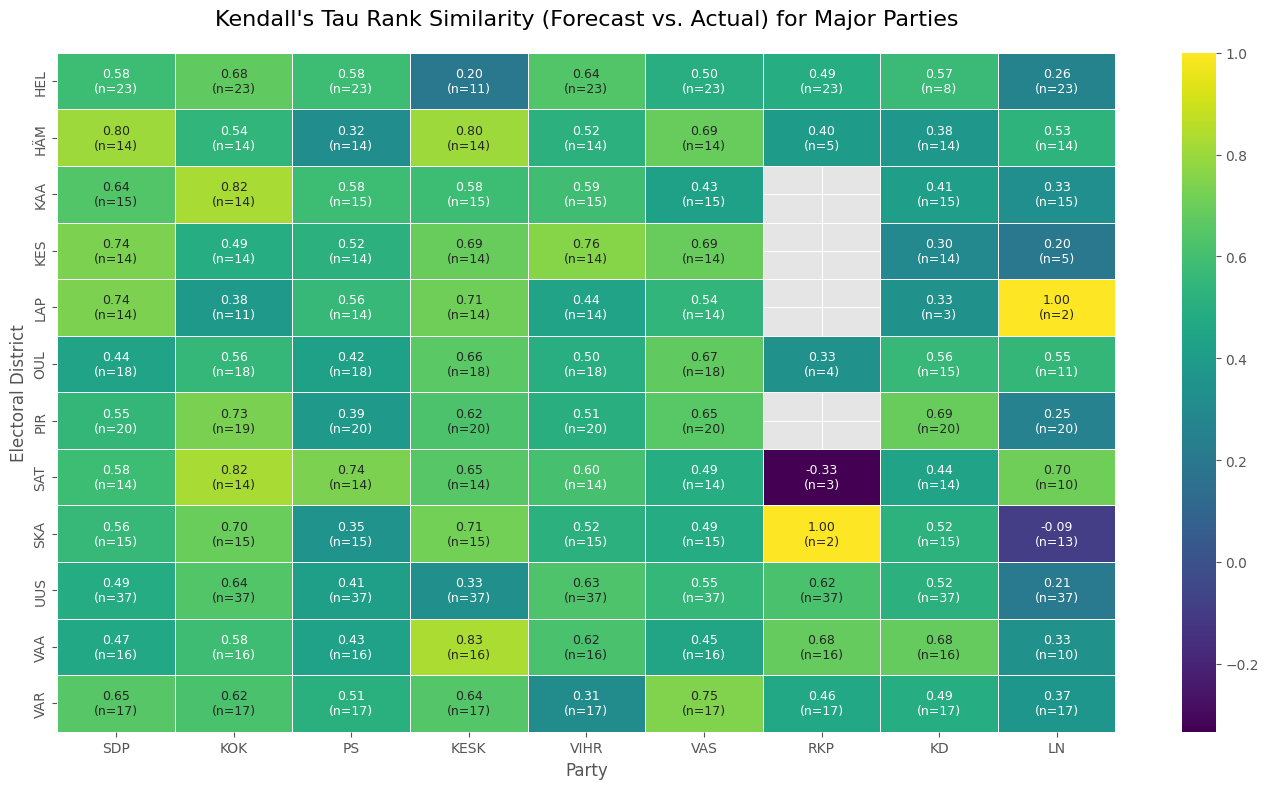


--- Plain Numeric Table (for copy-pasting) ---


party,SDP,KOK,PS,KESK,VIHR,VAS,RKP,KD,LN
district,,,,,,,,,
HEL,0.58,0.68,0.58,0.20,0.64,0.50,0.49,0.57,0.26
HÄM,0.80,0.54,0.32,0.80,0.52,0.69,0.40,0.38,0.53
KAA,0.64,0.82,0.58,0.58,0.59,0.43,NaN,0.41,0.33
KES,0.74,0.49,0.52,0.69,0.76,0.69,NaN,0.30,0.20
LAP,0.74,0.38,0.56,0.71,0.44,0.54,NaN,0.33,1.00
OUL,0.44,0.56,0.42,0.66,0.50,0.67,0.33,0.56,0.55
PIR,0.55,0.73,0.39,0.62,0.51,0.65,NaN,0.69,0.25
SAT,0.58,0.82,0.74,0.65,0.60,0.49,-0.33,0.44,0.70
SKA,0.56,0.70,0.35,0.71,0.52,0.49,1.00,0.52,-0.09




--- Analysis per District Only (based on candidates from major parties) ---


/var/folders/rw/tlr4y3fj0yd2_c4p1sgqzcg80000gn/T/ipykernel_41744/2976901830.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  district_only_stats = major_parties_df.groupby('district').apply(calculate_group_stats).reset_index()


,Kendall's Tau,Number of Candidates
district,,
HEL,0.627,180.000000
HÄM,0.725,117.000000
KAA,0.681,120.000000
KES,0.631,104.000000
LAP,0.522,87.000000
OUL,0.668,138.000000
PIR,0.656,160.000000
SAT,0.713,111.000000
SKA,0.635,120.000000


In [50]:

parties_with_candidates = ['KOK', 'KESK', 'SDP', 'PS', 'VIHR', 'RKP', 'KD', 'VAS', 'LN']
# MODIFICATION: Define the desired column order for parties.
party_order = ['SDP', 'KOK', 'PS', 'KESK', 'VIHR', 'VAS', 'RKP', 'KD', 'LN']

major_parties_df = test_xgb_result[test_xgb_result['party'].isin(parties_with_candidates)].copy()

def calculate_group_stats(group):
    """Calculates Kendall's Tau and the number of candidates for a group."""
    n = len(group)
    if n < 2:
        return pd.Series({'kendall_tau': None, 'n_candidates': n})
    tau, _ = kendalltau(group['prediction'], group['prefvote'])
    return pd.Series({'kendall_tau': tau, 'n_candidates': n})

# Apply the function to get both stats at once
combined_stats = major_parties_df.groupby(['district', 'party']).apply(calculate_group_stats).reset_index()
combined_stats['n_candidates'] = combined_stats['n_candidates'].astype(int)


# --- Heatmap Generation (Enhanced with Candidate Counts) ---

# Create the numerical pivot table for heatmap coloring
similarity_table_numeric = combined_stats.pivot_table(
    index='district', columns='party', values='kendall_tau'
)
# MODIFICATION: Reorder the columns based on the 'party_order' list.
similarity_table_numeric = similarity_table_numeric.reindex(columns=party_order)


# Create the formatted string labels for annotation
def create_annot_label(row):
    if pd.isna(row['kendall_tau']): return ''
    return f"{row['kendall_tau']:.2f}\n(n={row['n_candidates']})"
combined_stats['annot_label'] = combined_stats.apply(create_annot_label, axis=1)

# Create the annotation pivot table
annot_table_str = combined_stats.pivot_table(
    index='district', columns='party', values='annot_label', aggfunc='first'
)
# MODIFICATION: Reorder the columns here as well to match the numeric table.
annot_table_str = annot_table_str.reindex(columns=party_order)


# Generate the heatmap
print("--- Heatmap: Kendall's Tau per District and Party (with candidate count n) ---")
plt.figure(figsize=(14, 8))
sns.heatmap(
    similarity_table_numeric,
    annot=annot_table_str,
    fmt="",
    cmap='viridis',
    linewidths=.5,
    annot_kws={"size": 9}
)
plt.title("Kendall's Tau Rank Similarity (Forecast vs. Actual) for Major Parties", fontsize=16, pad=20)
plt.xlabel("Party", fontsize=12)
plt.ylabel("Electoral District", fontsize=12)
plt.tight_layout()
plt.show()


# --- Plain Table Output for Party-Level Analysis ---

print("\n--- Plain Numeric Table (for copy-pasting) ---")
display(similarity_table_numeric)


# ==============================================================================
# 2. SECONDARY ANALYSIS: Rank Similarity per District Only
# ==============================================================================

print("\n\n--- Analysis per District Only (based on candidates from major parties) ---")

district_only_stats = major_parties_df.groupby('district').apply(calculate_group_stats).reset_index()

district_only_stats = district_only_stats.set_index('district').rename(
    columns={'kendall_tau': "Kendall's Tau", 'n_candidates': 'Number of Candidates'}
)

display(district_only_stats.style.format({"Kendall's Tau": "{:.3f}"}).background_gradient(subset=["Kendall's Tau"], cmap='viridis'))

# D'hondt result calculation

This is for the final iteration, using the XGB regressor output. Its a duplicate of the earlier section, but needed here because it is used in later stages. The model can be easily chagned here, so the rest of the evaluation can be easily done for other models presented in the ML section.

In [51]:
## D'hondt results

# xgb: test_xgb_result
# rf: test_continuous_result
predicted_results = test_xgb_result

d_hondt_result = pd.DataFrame()
all_candidates = pd.DataFrame()

for index, row in districts.iterrows():
    district = predicted_results.loc[predicted_results['district'] == row['distabb']]
    
    
    # calculate district total vote
    df_party_vote = district.groupby('party')['prediction'].sum().reset_index().rename(columns={'prediction': 'party_district_vote'})
    district = district.merge(df_party_vote, on='party', how='left')
    
    # d'hondt vote share calculus 
    district["placement"] = 1
    district = district.sort_values(by=['party', 'prediction'], ascending=False)
    district['placement_divisor'] =  district.groupby('party')['placement'].cumsum()

    district['propotional_votes'] = district['party_district_vote'] / district['placement_divisor']
    
    district_results = district.nlargest(row['seats'], 'propotional_votes')
    d_hondt_result = pd.concat([district_results, d_hondt_result])
    all_candidates = pd.concat([all_candidates, district])
    
display(d_hondt_result.stb.freq(['elected']))
display(d_hondt_result.stb.freq(['party']))

,elected,count,percent,cumulative_count,cumulative_percent
0,1,151,75.50,151,75.50
1,0,49,24.50,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,43,21.50,43,21.50
1,SDP,39,19.50,82,41.00
2,PS,38,19.00,120,60.00
3,KESK,28,14.00,148,74.00
4,VIHR,18,9.00,166,83.00
5,VAS,16,8.00,182,91.00
6,RKP,10,5.00,192,96.00
7,KD,5,2.50,197,98.50
8,LN,2,1.00,199,99.50
9,FÅ,1,0.50,200,100.00


In [52]:
candidates_result = d_hondt_result.stb.freq(['elected'])
candidates_result.set_index(candidates_result.columns[0], inplace=True)
candidates_result.index = candidates_result.index.map({0: 'Not elected', 1: 'Elected'})
candidates_result.index.name=None
candidates_result[['count', 'percent']]

,count,percent
Elected,151,75.50
Not elected,49,24.50


# Model Evaluation

This section uses SHAP (SHapley Additive exPlanations) to interpret the XGBoost model and understand feature importance and interactions:

### SHAP Analysis Components

1. **Summary Plot**
   - Shows the impact of each feature on model predictions
   - Visualizes feature importance and directionality

2. **Bar Plot of Mean Absolute SHAP Values**
   - Ranks features by their average impact across all predictions
   - Identifies the most influential features globally

3. **Individual Predictions (Waterfall Plots)**
   - Detailed breakdown of specific candidate predictions
   - Shows how each feature contributes to individual outcomes

4. **Force Plot (Average)**
   - Visualizes the average prediction across all candidates
   - Shows how features push predictions above or below the base value

5. **Cohort Analysis by Party**
   - Compares feature importance across major parties (KOK, VIHR, SDP, PS)
   - Identifies party-specific patterns in predictions

6. **Violin Summary Plot**
   - Shows the distribution of SHAP values for each feature
   - Reveals non-linear relationships and interactions

### Key Insights
- Identifies which features drive model decisions
- Reveals non-linear patterns and feature interactions
- Provides transparency and interpretability

In [53]:
import shap

# Create a TreeExplainer for your trained XGBoost model
explainer = shap.Explainer(xgb_reg, train[features])

# Calculate SHAP values for the test set
shap_values = explainer(test[features])

# Define the mapping of feature codes to human-readable names
feature_mapping = dict(zip(features, feature_names))

# Replace the feature names in shap_values
shap_values.feature_names = [feature_mapping.get(name, name) for name in shap_values.feature_names]

shap.initjs()

/Users/tapio/code/personal/candidate-model/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


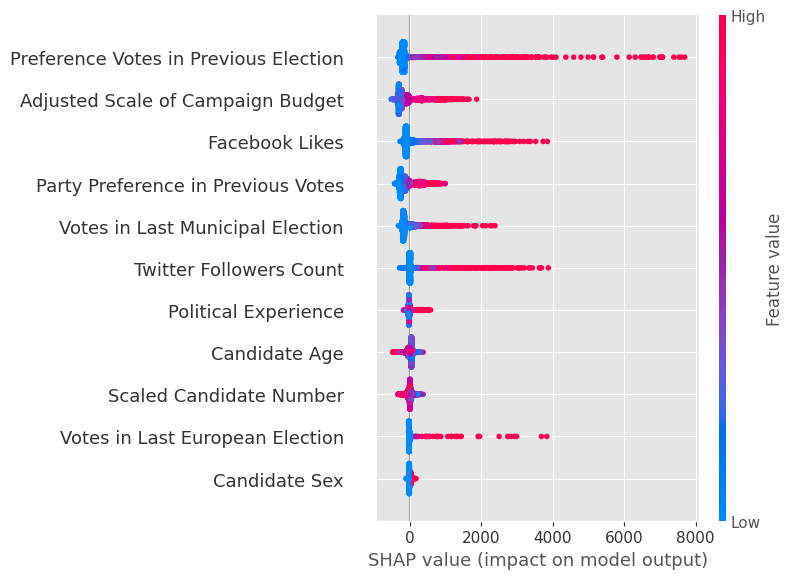

In [54]:
shap.summary_plot(shap_values)


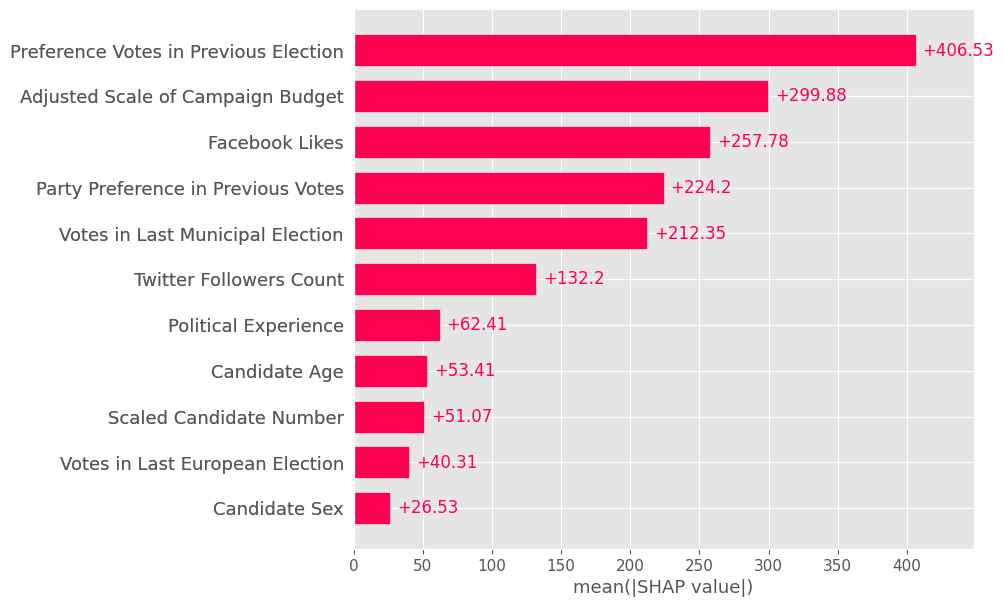

In [55]:
shap.plots.bar(shap_values, max_display=11)


In [56]:
# Assuming shap_values is a matrix-like object
shap_values_df = pd.DataFrame(shap_values.values, columns=features)

# Optionally, include the index or any other useful information
shap_values_df.index = test.index  # or some other identifier if needed

shap_values_df.head()

,party_prefvote_lag,prefvote_lag,age,sex,fb_likes,last_municipal_votes,last_eu_votes,political_experience,adjusted_campaign_budget_scale,twitter_followers,scaled_candidate_nr
0,108.69,-203.02,-18.90,-11.05,-114.00,-202.54,-24.26,-24.46,-305.54,-11.92,16.25
1,-157.64,-183.70,-25.57,-41.68,204.40,-146.97,-21.42,-38.17,-256.64,5.43,-2.27
2,-49.42,-195.16,-43.28,-27.30,-113.00,-148.59,-23.79,-27.00,-97.61,-0.36,-58.79
3,-61.42,-197.63,-91.57,-18.52,-139.84,-170.72,-24.92,-22.34,-119.45,3.98,22.07
4,-156.37,-173.96,19.72,-99.67,584.85,623.09,-20.55,-113.87,-96.03,226.91,-115.82


In [57]:
shap_values_df.describe()

,party_prefvote_lag,prefvote_lag,age,sex,fb_likes,last_municipal_votes,last_eu_votes,political_experience,adjusted_campaign_budget_scale,twitter_followers,scaled_candidate_nr
count,2424.00,2424.00,2424.00,2424.00,2424.00,2424.00,2424.00,2424.00,2424.00,2424.00,2424.00
mean,-53.52,60.59,12.91,0.89,118.08,-11.53,-0.19,20.66,-61.11,118.27,-1.80
std,256.85,925.49,71.02,31.85,517.73,311.89,208.59,115.84,376.17,469.78,79.20
min,-427.76,-336.41,-480.09,-103.01,-269.52,-322.02,-38.32,-179.87,-522.89,-290.76,-338.17
25%,-253.30,-215.30,-20.42,-19.18,-110.76,-183.57,-23.52,-29.10,-292.35,-2.86,-31.16
50%,-135.70,-197.05,30.68,-14.21,-90.36,-153.66,-22.54,-22.34,-223.55,1.89,2.95
75%,58.69,-169.72,50.55,20.90,67.62,49.45,-20.21,-9.47,-45.47,7.54,28.83
max,992.45,7692.01,373.96,172.49,3851.73,2384.47,3834.64,581.28,1869.76,3875.53,373.26


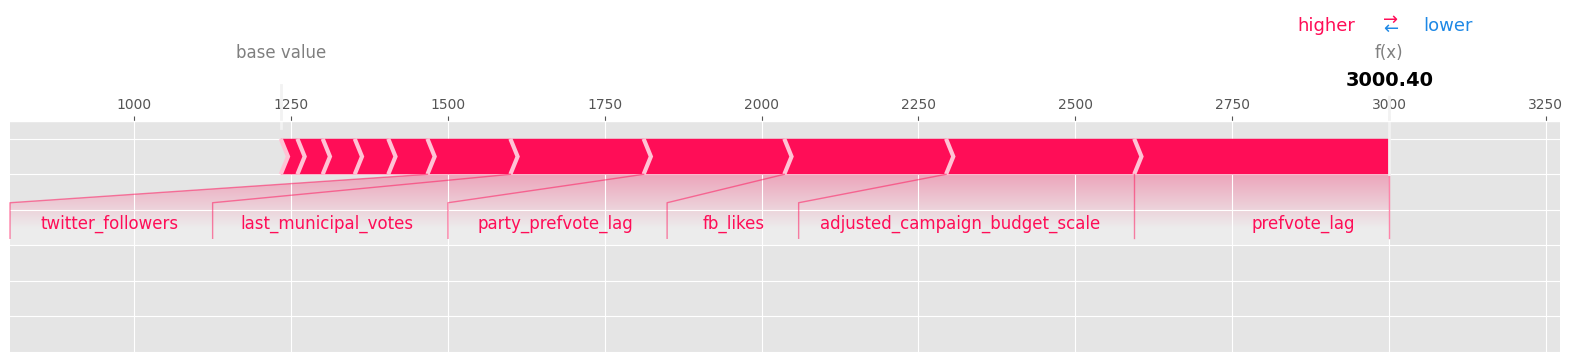

In [58]:
# Aggregate the SHAP values by taking the mean across all samples
mean_shap_values = np.mean(np.abs(shap_values.values), axis=0)

# Create an expected value for the model
expected_value = explainer.expected_value

# Create the force plot for the average SHAP values
shap.initjs()
shap.force_plot(
    expected_value,  # base value from the explainer
    mean_shap_values,  # average SHAP values
    features=test[features].columns.tolist(),  # feature names
    matplotlib=True  # use matplotlib to render the plot
)

In [59]:
# Create a DataFrame for the mean SHAP values
mean_shap_df = pd.DataFrame({
    'feature': test[features].columns.tolist(),
    'mean_abs_shap_value': mean_shap_values
})
mean_shap_df

,feature,mean_abs_shap_value
0,party_prefvote_lag,224.20
1,prefvote_lag,406.53
2,age,53.41
3,sex,26.53
4,fb_likes,257.78
5,last_municipal_votes,212.35
6,last_eu_votes,40.31
7,political_experience,62.41
8,adjusted_campaign_budget_scale,299.88
9,twitter_followers,132.20


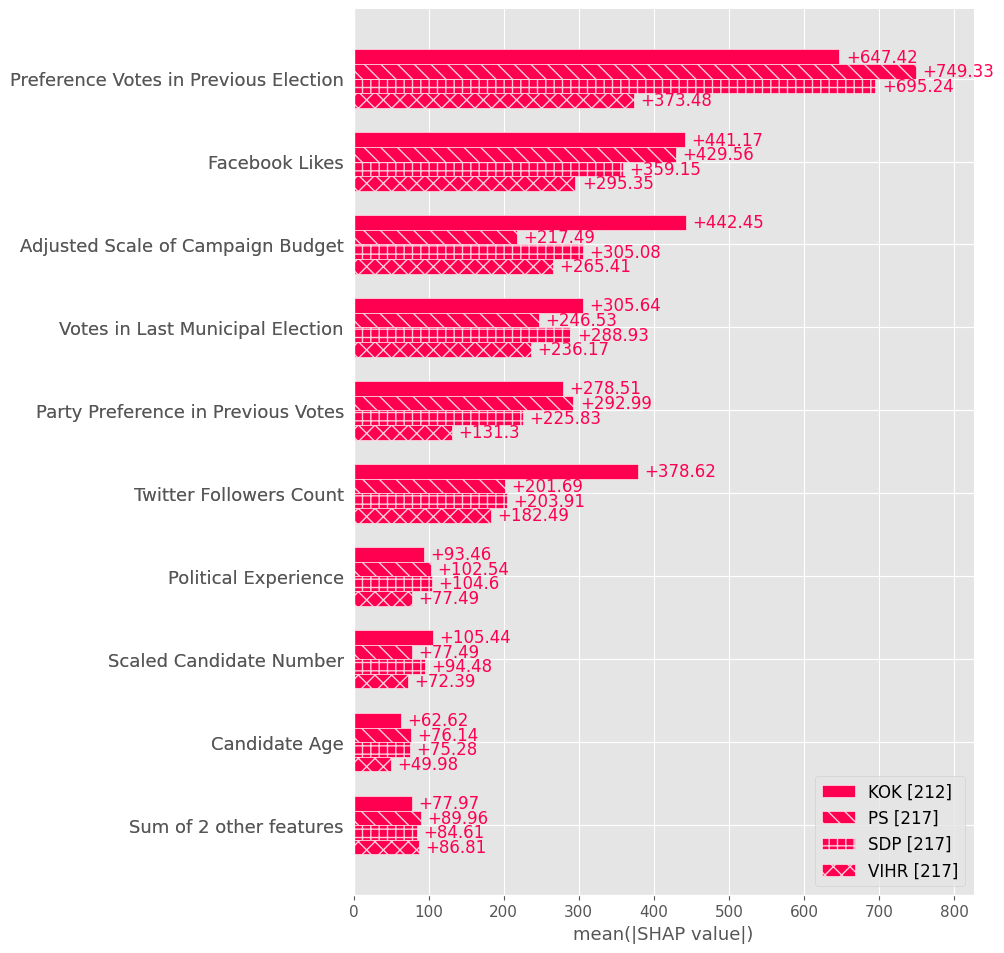

In [60]:
parties_of_interest = ['KOK', 'VIHR', 'SDP', 'PS']

# Filter the test dataset and SHAP values to include only the specified parties
filtered_indices = test['party'].isin(parties_of_interest)
filtered_shap_values = shap.Explanation(
    values=shap_values.values[filtered_indices],
    base_values=shap_values.base_values[filtered_indices],
    data=shap_values.data[filtered_indices],
    feature_names=shap_values.feature_names
)

# Use the "party" column from the filtered test data as cohort labels
party_cohorts = test[filtered_indices]['party'].values

# Create cohort-based SHAP values for filtered data
cohort_shap_values = filtered_shap_values.cohorts(party_cohorts)

# Visualize the average absolute SHAP values for each cohort
shap.plots.bar(cohort_shap_values.abs.mean(0))

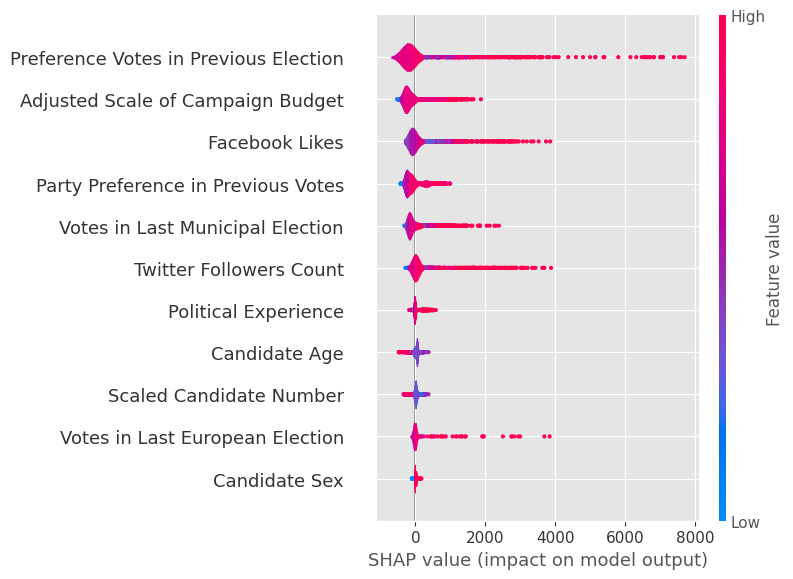

In [61]:
shap.summary_plot(shap_values, test[features], feature_names=feature_names, plot_type='violin')

In [62]:
# Extract SHAP values and feature names
shap_values_array = shap_values.values
feature_names = test[features].columns

# Create a DataFrame with SHAP values
shap_df = pd.DataFrame(shap_values_array, columns=feature_names)
shap_df


,party_prefvote_lag,prefvote_lag,age,sex,fb_likes,last_municipal_votes,last_eu_votes,political_experience,adjusted_campaign_budget_scale,twitter_followers,scaled_candidate_nr
0,108.69,-203.02,-18.90,-11.05,-114.00,-202.54,-24.26,-24.46,-305.54,-11.92,16.25
1,-157.64,-183.70,-25.57,-41.68,204.40,-146.97,-21.42,-38.17,-256.64,5.43,-2.27
2,-49.42,-195.16,-43.28,-27.30,-113.00,-148.59,-23.79,-27.00,-97.61,-0.36,-58.79
3,-61.42,-197.63,-91.57,-18.52,-139.84,-170.72,-24.92,-22.34,-119.45,3.98,22.07
4,-156.37,-173.96,19.72,-99.67,584.85,623.09,-20.55,-113.87,-96.03,226.91,-115.82
...,...,...,...,...,...,...,...,...,...,...,...
2419,-238.91,-192.98,-53.29,-13.11,-121.24,-155.49,-21.63,-11.04,-320.65,2.80,2.32
2420,-292.34,-220.01,40.18,-14.77,-80.99,-152.52,-23.57,-25.79,-309.12,3.82,7.42
2421,-274.49,-169.17,-48.80,-15.02,-104.30,-154.88,-21.97,-19.10,-297.54,-2.51,9.20
2422,-273.36,-204.16,-35.55,13.90,-117.25,-148.95,-22.11,-24.68,-327.55,-0.22,10.23


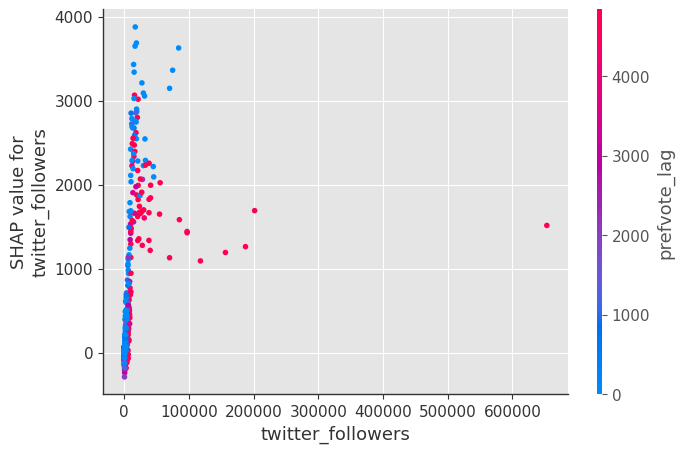

In [63]:

shap.dependence_plot('twitter_followers', shap_values.values, test[features])


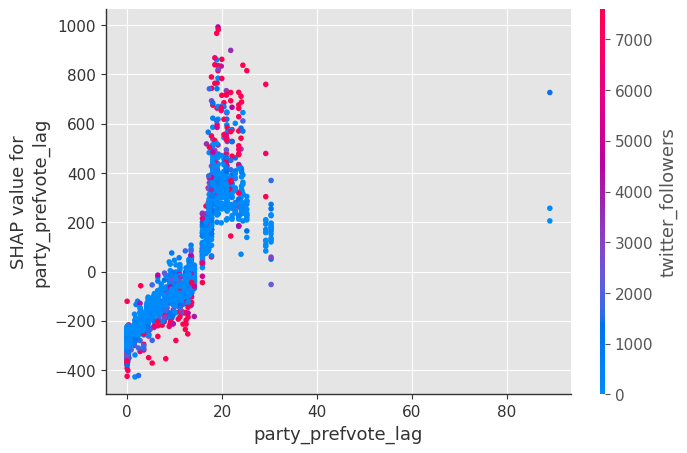

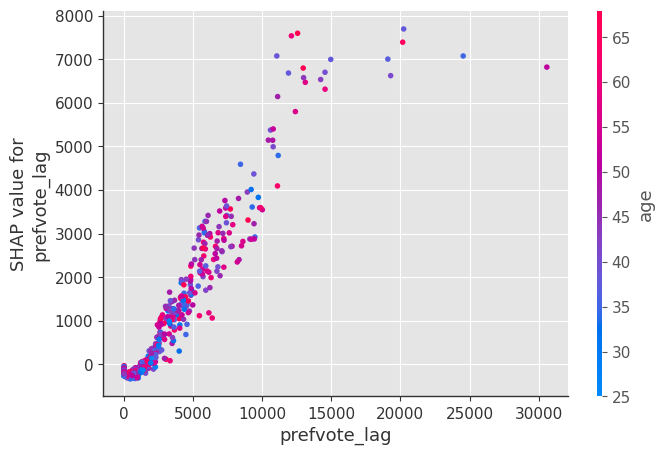

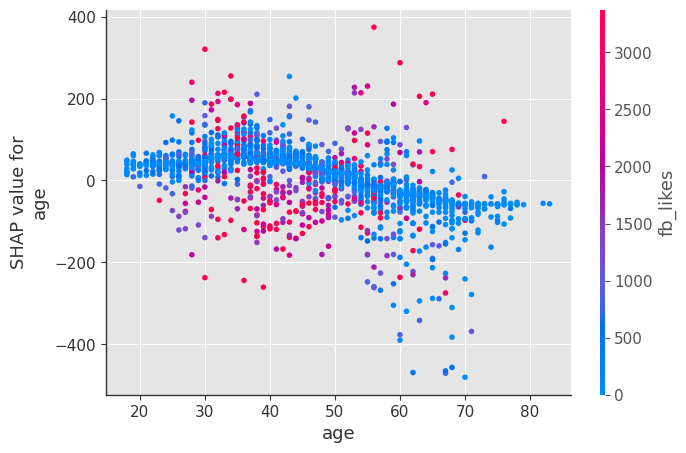

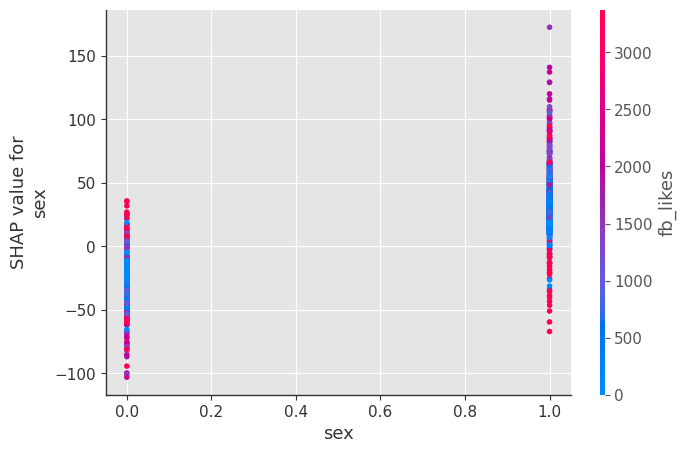

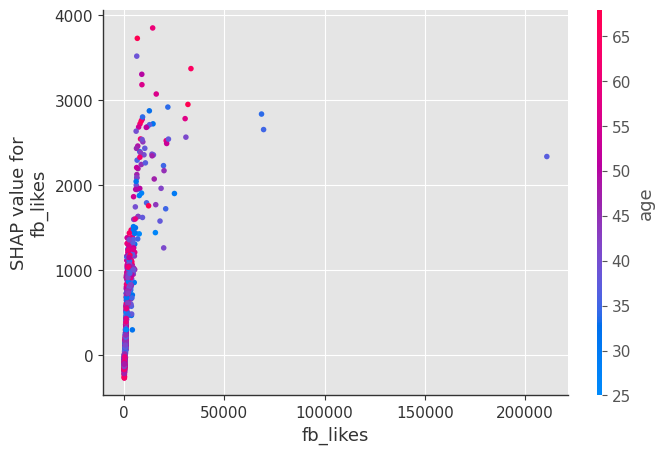

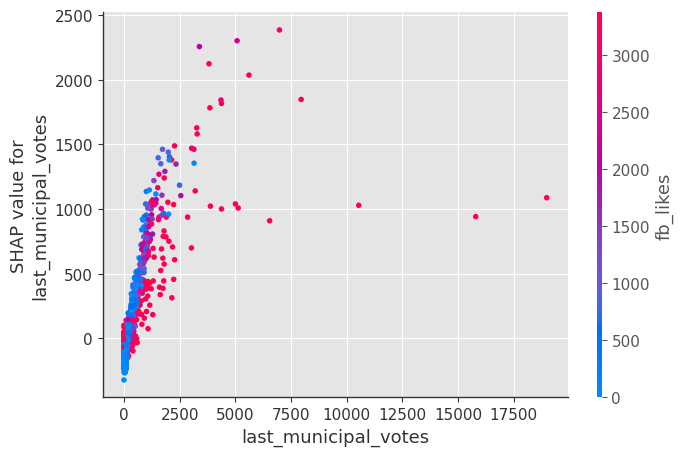

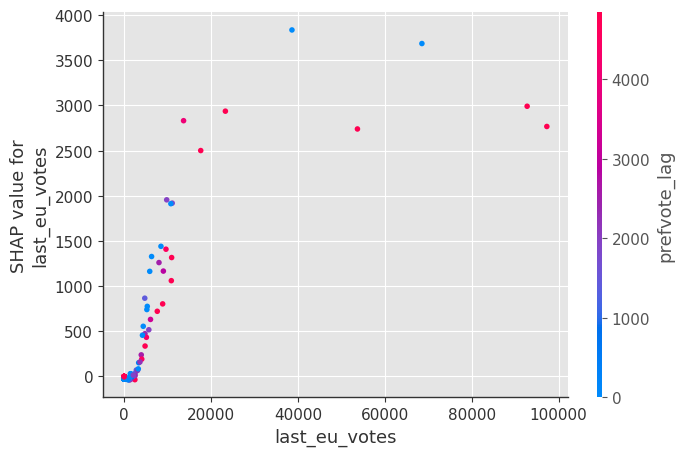

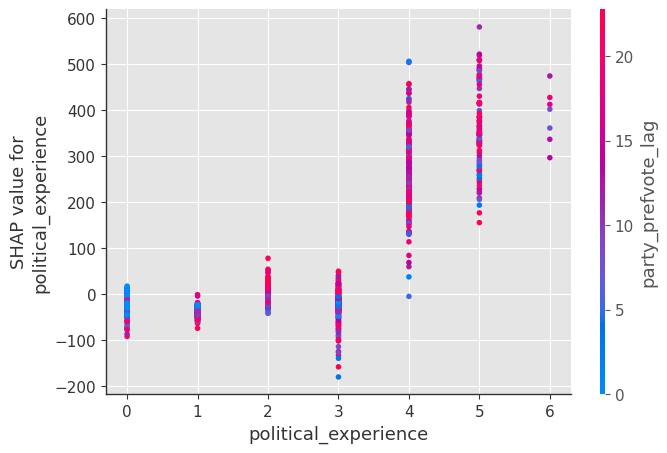

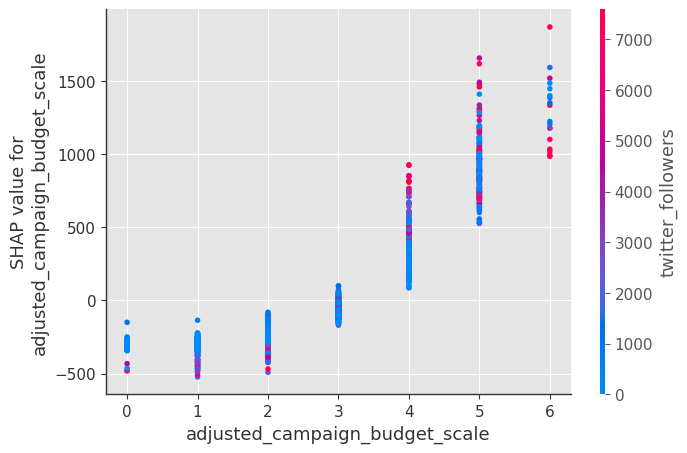

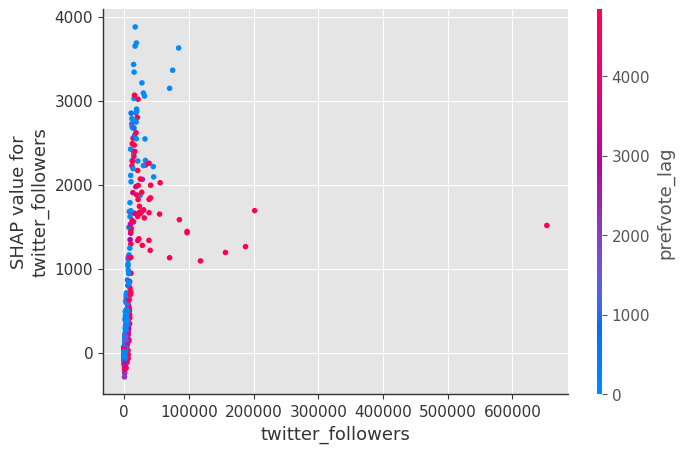

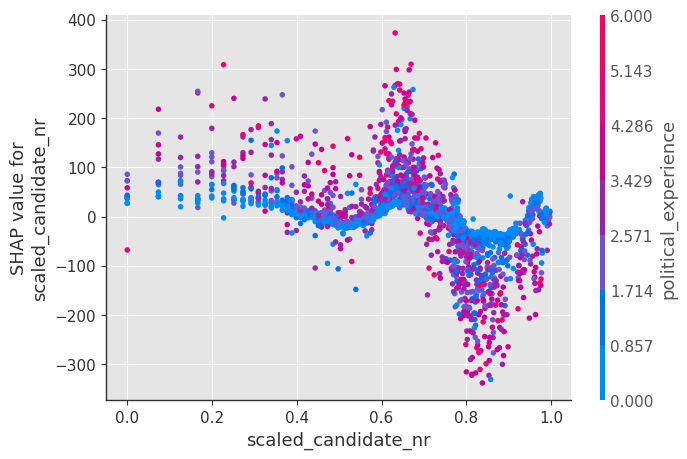

In [64]:
# Assuming shap_values and test[features] are already defined
feature_names = test[features].columns



# Loop through all the features and create a dependence plot for each
for feature in feature_names:
    shap.dependence_plot(feature, shap_values.values, test[features])

# Performance evaluation

To evaluate the predictive performacne of the model, this section compares the results produced with the model with the actual results from the elections.

### Evaluation Components

1. **Poll Aggregation**
   - Collects and averages pre-election polls

2. **Previous Election Baseline**
   - Uses 2019 election results as naive baseline
   - Tests if model adds value beyond historical data

3. **National Vote Share Comparison**
   - Compares predicted vs actual party vote percentages
   - Calculates Mean Absolute Error (MAE) for:
     - ML model predictions
     - Poll averages
     - Historical baseline

4. **Seat Allocation Accuracy**
   - Evaluates parliamentary seat predictions per party
   - Compares predicted seat distribution to actual outcomes
   - Measures MAE for seat counts

5. **Model Comparison Matrix**
   - Side-by-side comparison of all 8 regression models
   - Metrics: MAE, Precision, Recall, F1, Accuracy, Kendall's Tau
   - Identifies best-performing approach

### Success Metrics
- **Vote Share MAE**: How accurately the model predicts party percentages
- **Seat Prediction Accuracy**: How well it forecasts parliamentary composition
- **Ranking Correlation**: Whether candidate order within parties is correct
- **Comparison to Baselines**: Does ML outperform polls and historical data?

In [65]:
polls_2023 = polls.loc[polls['year'] == 2023]

In [66]:
# Predictions
predicted_percentages = final_prediction_candidates

In [67]:
poll_average_2023 = polls_2023.groupby('party', as_index=False)['share'].mean()

In [68]:
# Poll averages

poll_average_2023 = polls_2023.groupby('party', as_index=False)['share'].mean()
poll_average_2023['poll_average'] = poll_average_2023['share']
poll_average_2023 = poll_average_2023[['party','poll_average']]

In [69]:
# Baseline
result_2019 = candidates.loc[candidates['year'] == 2019]
seats_2019 = result_2019.loc[result_2019['elected'] == 1]

In [70]:
# Results 
result_2023 = candidates.loc[candidates['year'] == 2023]
seats_2023 = result_2023.loc[result_2023['elected'] == 1]
baseline_seats = seats_2019.stb.freq(['party'], value='elected')

In [71]:
polled_parties = ['KOK', 'KESK', 'SDP', 'PS', 'VIHR', 'RKP', 'KD', 'VAS', 'LN']

In [72]:
# calculate percentage totals 
percentage_totals = result_2023.stb.freq(['party'], value='prefvote')
percentage_totals_others = percentage_totals.loc[~percentage_totals.party.isin(polled_parties)]
percentage_totals = percentage_totals.loc[percentage_totals.party.isin(polled_parties)]
percentage_totals.loc[len(percentage_totals.index)+1] = ['Muut',percentage_totals_others.sum().prefvote, percentage_totals_others.sum().percent, percentage_totals_others.cumulative_prefvote.mean(),100]
percentage_totals['actual'] =  percentage_totals['percent']
percentage_totals = percentage_totals[['party', 'actual']]

In [73]:
# baseline is 2015 result
baseline_percentage = result_2019.stb.freq(['party'], value='prefvote')
baseline_percentage_others = baseline_percentage.loc[~baseline_percentage.party.isin(polled_parties)]
baseline_percentage = baseline_percentage.loc[baseline_percentage.party.isin(polled_parties)]
baseline_percentage.loc[len(baseline_percentage.index)+1] = ['Muut',baseline_percentage_others.sum().prefvote, baseline_percentage_others.sum().percent, baseline_percentage_others.cumulative_prefvote.mean(),100]
baseline_percentage['baseline'] =  baseline_percentage['percent']
baseline_percentage = baseline_percentage[['party', 'baseline']]

In [74]:
# and here is the forecast, should we use the predicted proptional votes or predicted preference votes? 
# param name: "propotional_votes"
predicted_percentage_totals = predicted_percentages.stb.freq(['party'], value='propotional_votes')
predicted_percentage_totals_others = predicted_percentage_totals.loc[~predicted_percentage_totals.party.isin(polled_parties)]
predicted_percentage_totals = predicted_percentage_totals.loc[predicted_percentage_totals.party.isin(polled_parties)]
predicted_percentage_totals.loc[len(predicted_percentage_totals.index)+1] = ['Muut',predicted_percentage_totals_others.sum().percent, predicted_percentage_totals_others.sum().percent, predicted_percentage_totals_others.cumulative_percent.mean(),100] 
predicted_percentage_totals['propotional_votes'] =  predicted_percentage_totals['percent']
predicted_percentage_totals = predicted_percentage_totals[['party', 'propotional_votes']]

In [75]:
# Combine actual, predicted, baseline, and poll averages
combined_totals = pd.merge(percentage_totals, baseline_percentage, on="party", how="outer")
combined_totals = pd.merge(combined_totals, predicted_percentage_totals, on="party", how="outer")
combined_totals = pd.merge(combined_totals, poll_average_2023, on="party", how="outer")
combined_totals.fillna(0, inplace=True)
combined_totals.rename(columns={"propotional_votes": "prediction"}, inplace=True)
combined_totals

,party,actual,baseline,prediction,poll_average
0,KD,4.22,3.90,3.56,4.20
1,KESK,11.29,13.76,11.78,11.05
2,KOK,20.82,17.00,19.74,19.80
3,LN,2.42,2.25,2.81,1.85
4,Muut,2.82,3.68,4.12,3.30
5,PS,20.06,17.48,16.48,19.35
6,RKP,4.31,4.53,5.28,4.30
7,SDP,19.95,17.73,17.16,18.95
8,VAS,7.06,8.17,8.48,8.50
9,VIHR,7.04,11.49,10.60,8.70


In [76]:
# Optional: Generate latex table
# First, sort the DataFrame by the 'actual' column
# combined_totals_sorted = combined_totals.sort_values(by='actual', ascending=False)

# Then convert the sorted DataFrame to LaTeX format
# latex_table = combined_totals_sorted.to_latex(index=False,
#                                              caption="National Results",
#                                              float_format="{:.2f}".format)

# latex_table
# Print the LaTeX table
# print(latex_table)

In [77]:
# MAE for percentages
poll_mae = metrics.mean_absolute_error(combined_totals.poll_average, combined_totals.actual)
predicted_mae = metrics.mean_absolute_error(combined_totals.prediction, combined_totals.actual)
baseline_mae = metrics.mean_absolute_error(combined_totals.baseline, combined_totals.actual)

print(poll_mae)
print(predicted_mae)
print(baseline_mae)

0.7164630415384919
1.6242312296857904
1.822749375830621


In [78]:
# Sort the DataFrame by the 'actual' column
combined_totals_sorted = combined_totals.sort_values(by='actual', ascending=False)

# Convert the sorted DataFrame to LaTeX format with a new variable name
poll_comparison_latex = combined_totals_sorted.to_latex(index=False,
                                                        caption="National Results",
                                                        float_format="{:.2f}".format)

# Calculate MAE for each
poll_mae = metrics.mean_absolute_error(combined_totals.poll_average, combined_totals.actual)
predicted_mae = metrics.mean_absolute_error(combined_totals.prediction, combined_totals.actual)
baseline_mae = metrics.mean_absolute_error(combined_totals.baseline, combined_totals.actual)

# Print MAE values for debugging (optional)
print(poll_mae)
print(predicted_mae)
print(baseline_mae)

# Build the new row for the MAE values, leaving the "Actual" column empty
mae_row = " & ".join(["MAE", "{:.2f}".format(baseline_mae), "{:.2f}".format(predicted_mae), "{:.2f}".format(poll_mae), ""]) + " \\\\"
baseline_mae
# Find the position where the data rows end in the LaTeX table (before the '\bottomrule')
end_of_table = poll_comparison_latex.rfind(r'\bottomrule')
# Insert the MAE row just before the table ends
poll_comparison_latex_with_mae = poll_comparison_latex[:end_of_table] + mae_row + "\n" + poll_comparison_latex[end_of_table:]

# Print the new LaTeX table with the MAE row
print(poll_comparison_latex_with_mae)

0.7164630415384919
1.6242312296857904
1.822749375830621
\begin{table}
\caption{National Results}
\begin{tabular}{lrrrr}
\toprule
party & actual & baseline & prediction & poll_average \\
\midrule
KOK & 20.82 & 17.00 & 19.74 & 19.80 \\
PS & 20.06 & 17.48 & 16.48 & 19.35 \\
SDP & 19.95 & 17.73 & 17.16 & 18.95 \\
KESK & 11.29 & 13.76 & 11.78 & 11.05 \\
VAS & 7.06 & 8.17 & 8.48 & 8.50 \\
VIHR & 7.04 & 11.49 & 10.60 & 8.70 \\
RKP & 4.31 & 4.53 & 5.28 & 4.30 \\
KD & 4.22 & 3.90 & 3.56 & 4.20 \\
Muut & 2.82 & 3.68 & 4.12 & 3.30 \\
LN & 2.42 & 2.25 & 2.81 & 1.85 \\
MAE & 1.82 & 1.62 & 0.72 &  \\
\bottomrule
\end{tabular}
\end{table}



In [79]:
# Baseline seats
baseline_seats = result_2019.stb.freq(['party'], value='elected')
baseline_seats['baseline'] = baseline_seats['elected']

# Result seats
actual_seats = result_2023.stb.freq(['party'], value='elected')
actual_seats['actual'] = actual_seats['elected']

# Predicted seats
predicted_candidates = final_prediction_candidates[final_prediction_candidates['prediction_classification'] == 1]
predicted_seats = predicted_candidates.stb.freq(['party'])
predicted_seats['prediction'] = predicted_seats['count']

In [80]:
# Join all into same dataframe
combined_seats = pd.merge(actual_seats, baseline_seats, on="party", how="outer")
combined_seats = pd.merge(combined_seats, predicted_seats, on="party", how="outer")
combined_seats = combined_seats[['party', 'baseline', 'prediction', 'actual']]
combined_seats.fillna(0, inplace=True)

In [81]:
combined_seats

,party,baseline,prediction,actual
0,FÅ,1,1,1
1,KD,5,5,5
2,KESK,31,28,23
3,KOK,38,43,48
4,LN,1,2,1
5,PS,39,38,46
6,RKP,9,10,9
7,SDP,40,39,43
8,VAS,16,16,11
9,VIHR,20,18,13


In [82]:
# MAE for percentages
predicted_seats_mae = metrics.mean_absolute_error(combined_seats.prediction, combined_seats.actual)
baseline_seats_mae = metrics.mean_absolute_error(combined_seats.baseline, combined_seats.actual)

print(predicted_seats_mae)
print(baseline_seats_mae)

3.4
4.0


# Model Comparison

In [83]:
# comparison of models
display(performance_metrics)


,MAE,Precision,Recall,F1,Accuracy,Kendall rank correlation
Model,,,,,,
XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67
Ridge,640.45,0.75,0.75,0.75,0.96,0.67
XGBRegressor,635.14,0.76,0.76,0.76,0.96,0.68
RandomForestRegressor,629.60,0.76,0.76,0.76,0.96,0.68
LinearRegression,640.75,0.74,0.74,0.74,0.96,0.67
LinearRegression(LOG),648.58,0.73,0.73,0.73,0.96,0.67


In [84]:
# Optional: create a latex table
# print(performance_metrics.to_latex(index=False,
#                  caption="Table 4: Performance Metrics",
#                  float_format="{:.2f}".format,
#
#)) 

In [85]:
f_importance = xgb_reg.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.rename(columns={0: 'Importance'}, inplace=True)

scaler = MinMaxScaler() 
df_scaled = scaler.fit_transform(importance_df)
importance_df['Scaled'] = df_scaled
importance_df.sort_values('Scaled', ascending=False, inplace=True)

importance_df.rename(index={
    'prefvote' : 'Preference votes',
    'party_prefvote_lag': 'Percentage of votes received by the party in the last parliamentary elections',
    'prefvote_lag' : 'Preference votes received by the candidate in the last parliamentary elections',
    'age' : 'Age',
    'fb_likes' : 'Facebook likes',
    'twitter_followers:' : 'Twitter followers',
    'last_presidential_elections' : 'Votes received by the candidate in the last presidential elections',
    'last_municipal_votes' : 'Votes received by the candidate in the last municipal elections',
    'last_eu_votes' : 'Votes in the last European Parliament elections',
    'dist_bkt_change' : 'The change of BKT of the electoral district last four years',
    'political_experience' : 'Political experience',
    'campaign_budget_scale' : 'Self-reported campaign budget',    
    'sex': 'Sex',
    'party_changed' : 'Changed party between the current and last parliamentary elections',
    'cabinet_last_parliament' : 'The party held cabinet in the last parliament'}, inplace=True)


#fig, ax = plt.subplots()
#sns.barplot(data=importance_df[['Scaled']].T, orient='h')
#ax.set_title("XGB Regressor feature importances")
#plt.show()
importance_df

,Importance,Scaled
Preference votes received by the candidate in the last parliamentary elections,147787632.00,1.00
Votes in the last European Parliament elections,95670720.00,0.63
adjusted_campaign_budget_scale,56918432.00,0.36
twitter_followers,30925000.00,0.17
Political experience,25349914.00,0.13
Facebook likes,21261626.00,0.10
Votes received by the candidate in the last municipal elections,13020845.00,0.05
Percentage of votes received by the party in the last parliamentary elections,11534931.00,0.04
Age,8931035.00,0.02
scaled_candidate_nr,7343209.50,0.01


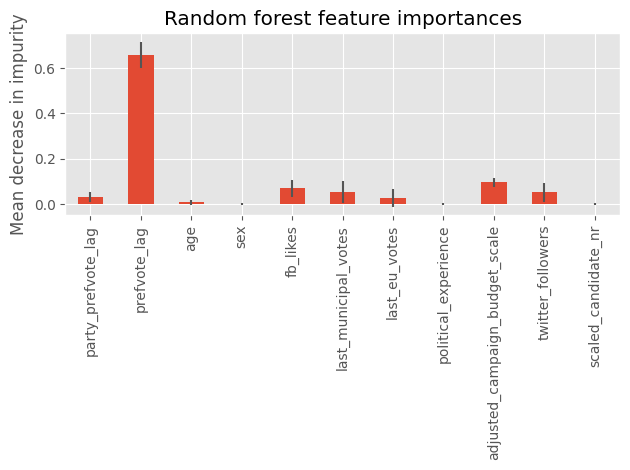

In [86]:
# Let's see feature importance metrics!
feature_names = [f"feature {i}" for i in range(train[features].shape[1])]
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index=features)

std = np.std([tree.feature_importances_ for tree in rnd_clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random forest feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# Most features seem rather unrelevant

# Model Diagram

Visualizes the parameters and their distributions fed into the model

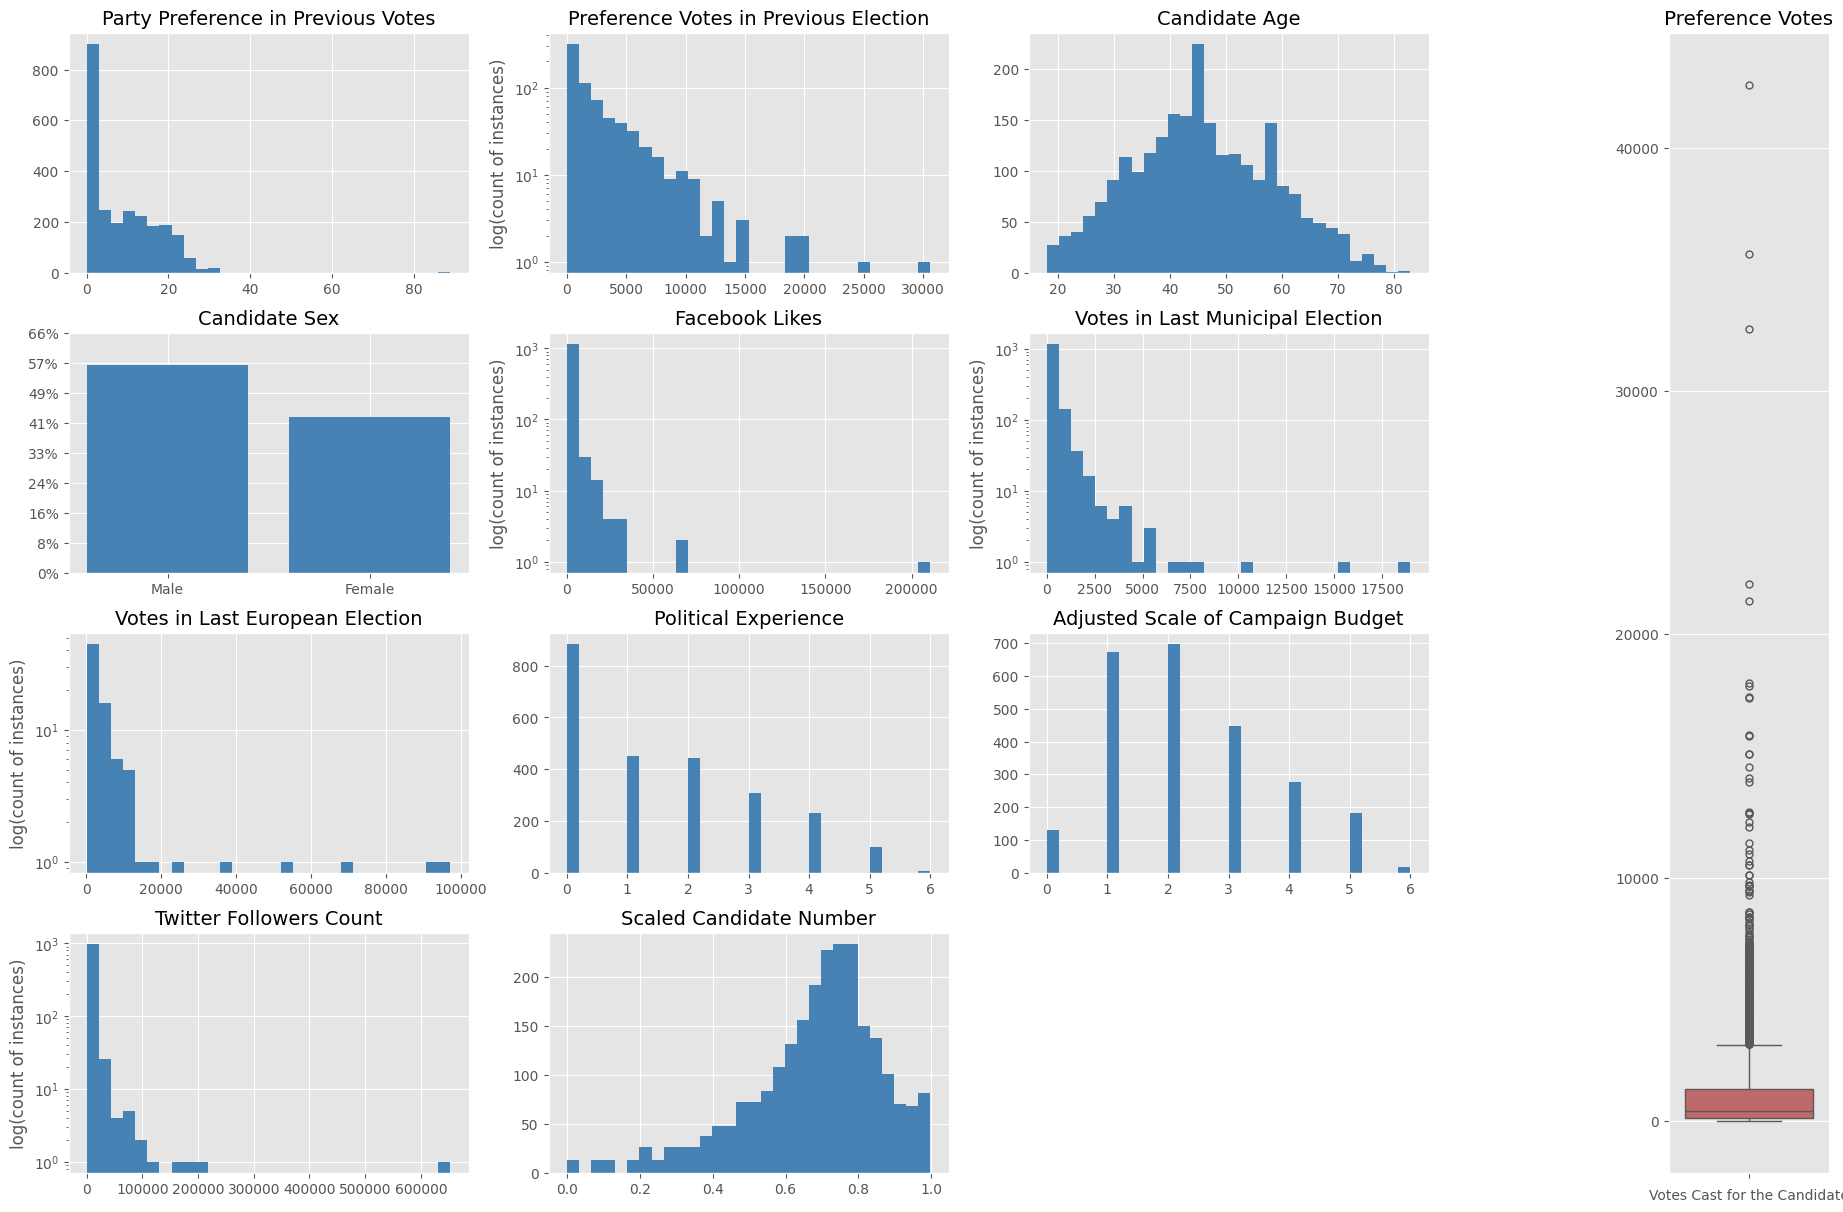

In [87]:
plt.style.use('ggplot')

features = [
    'party_prefvote_lag',
    'prefvote_lag',
    'age',
    'sex',  # Binary variable
    'fb_likes',
    'last_municipal_votes',
    'last_eu_votes',
    'political_experience',
    'adjusted_campaign_budget_scale',
    'twitter_followers',
    'scaled_candidate_nr'
]
target = 'prefvote'

feature_names = ['Party Preference in Previous Votes',
                 'Preference Votes in Previous Election',
                 'Candidate Age',
                 'Candidate Sex',
                 'Facebook Likes',
                 'Votes in Last Municipal Election',
                 'Votes in Last European Election',
                 'Political Experience',
                 'Adjusted Scale of Campaign Budget',
                 'Twitter Followers Count',
                 'Scaled Candidate Number'
                ]

# Custom figure size and layout
fig = plt.figure(figsize=(16, 12))

# Loop to create histograms
for idx, column in enumerate(features):
    ax = fig.add_axes([0.05 + (idx % 3) * 0.3, 0.75 - (idx // 3) * 0.25, 0.25, 0.2])
    data = all_candidates[column]
    
    if column == 'sex':
        sex_counts = data.value_counts().sort_index()
        ax.bar(sex_counts.index, sex_counts.values, color='steelblue')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Male', 'Female'])

        # --- Set y-axis to percentage ---
        total = len(data)
        
        # Get the current tick locations that matplotlib automatically chose
        current_ticks = ax.get_yticks()
        
        # Create new labels from the tick values by calculating the percentage
        new_labels = [f'{int(100 * tick / total)}%' for tick in current_ticks]
        
        # Apply the new labels to the ticks
        ax.set_yticks(current_ticks) # Set the tick positions
        ax.set_yticklabels(new_labels) # Set the tick labels
    # --- End of the modification ---
    elif column in ['fb_likes', 'twitter_followers', 'prefvote_lag', 'last_municipal_votes', 'last_eu_votes']:
        ax.hist(data[data > 0], bins=30, color='steelblue', log=True)
        ax.set_ylabel('log(count of instances)')
    else:
        ax.hist(data, bins=30, color='steelblue')
        
    ax.set_title(feature_names[idx], fontsize=14)
    ax.set_xlabel('')

# Adding the boxplot separately and shifting it to the right
axbox = fig.add_axes([1.05, 0, 0.1, 0.95])  # Increase 'left', maintain 'width'
sns.boxplot(y=all_candidates[target], ax=axbox, color='indianred', whis=1.5, fliersize=5)
axbox.set_title('Preference Votes')
axbox.set_xlabel('Votes Cast for the Candidate', fontsize=10)
axbox.set_ylabel('')

# Save and show the plot
plt.savefig("model_input_variables.png", bbox_inches='tight', dpi=300)
plt.show()

# Future development
1. Rank candidates (intraparty, machine learning regression)
2. Estimate party list quality (sum candidates estimated preference votes per each district)
3. Predict regional result based on quality of candidates (normalized estimated vote according to step 2), political, and economical trends
4. Get n. top candidates from each list
5. Use candidate locality as a predictor
6. Include municipal votes
7. Calculate regional votes with d'hondt

# Classifier algorithms

Here is one example with using a RandomForestClassifier algorithm for comparison against the regressors.

In [88]:
# Classifiers

from sklearn.ensemble import RandomForestClassifier

# Define model, random state is there for making reproducible estimates
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=32)

rnd_clf.fit(train[features], train.elected)

prediction_rf_classification = rnd_clf.predict_proba(test[features])

# Assing prediction to dataframe
test_classification_result = test.copy()
test_classification_result["prediction"] = prediction_rf_classification[:,1]

prediction_rf_classification_result = test_classification_result.nlargest(200, 'prediction')
display(prediction_rf_classification_result.stb.freq(['elected']))
display(prediction_rf_classification_result.stb.freq(['party']))

prediction_rf_classification_result.loc[prediction_rf_classification_result['prefvote_lag'] == 0]

,elected,count,percent,cumulative_count,cumulative_percent
0,1,148,74.00,148,74.00
1,0,52,26.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,42,21.00,42,21.00
1,SDP,39,19.50,81,40.50
2,PS,37,18.50,118,59.00
3,KESK,28,14.00,146,73.00
4,VIHR,20,10.00,166,83.00
5,VAS,14,7.00,180,90.00
6,RKP,12,6.00,192,96.00
7,KD,4,2.00,196,98.00
8,LN,3,1.50,199,99.50
9,FÅ,1,0.50,200,100.00


,year,last_election,candidate_id,district,district_id,party,party_id,party_prefvote_lag,candidate_nr,prefvote,...,municipal_candidate,political_experience,campaign_budget_reported,campaign_budget_scale,education_scale,campaign_budget_scale_2023,adjusted_campaign_budget_scale,log_candidate_nr,scaled_candidate_nr,prediction
1140,2023,2019,18507,UUS,2,SDP,2,17.76,251,5445,...,0,2,0,5.00,alempi korkeakoulututkinto,5,5.00,5.53,0.88,0.57
914,2023,2019,18897,HEL,1,VAS,5,11.13,76,10112,...,1,2,0,4.00,ylempi korkeakoulututkinto,4,4.00,4.33,0.66,0.54
1206,2023,2019,18898,HEL,1,SDP,2,13.59,189,14108,...,1,2,0,5.00,ylempi korkeakoulututkinto,5,5.00,5.24,0.83,0.54


In [89]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(train[features], train.elected)
prediction_xgb_clf = xgb_clf.predict_proba(test[features])

# Assing prediction to dataframe
test_xgb_clf_result = test.copy()
test_xgb_clf_result["prediction"] = prediction_xgb_clf[:,1]

prediction_xgb_clf_result = test_xgb_clf_result.nlargest(200, 'prediction')
display(prediction_xgb_clf_result.stb.freq(['elected']))
display(prediction_xgb_clf_result.stb.freq(['party']))

,elected,count,percent,cumulative_count,cumulative_percent
0,1,142,71.00,142,71.00
1,0,58,29.00,200,100.00


,party,count,percent,cumulative_count,cumulative_percent
0,KOK,53,26.50,53,26.50
1,PS,35,17.50,88,44.00
2,SDP,33,16.50,121,60.50
3,KESK,26,13.00,147,73.50
4,VIHR,18,9.00,165,82.50
5,VAS,17,8.50,182,91.00
6,RKP,10,5.00,192,96.00
7,KD,5,2.50,197,98.50
8,VL,1,0.50,198,99.00
9,FÅ,1,0.50,199,99.50
